In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from io import StringIO
from glob import glob
import wandb
import os
import molgrid
from argparse import Namespace
import torch
from scipy.stats import pearsonr
import re
import seaborn as sns
%matplotlib inline

In [295]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)
%matplotlib inline
PR_lab = "Pearson's R"
RMSE_lab = r"RMSE (pK)"
MAE_lab = r"MAE (pK)"

In [313]:
pub_api = wandb.apis.public.Api()

In [218]:
def get_stats(epoch, pred_ddg, actual_ddg, pred_abs, actual_abs):
    try:
        r_ddg, _ = pearsonr(np.array(actual_ddg), np.array(pred_ddg))
    except ValueError as e:
        print('{}:{}'.format(epoch, e))
        r_ddg = np.nan
    try:
        r_abs, _ = pearsonr(np.array(pred_abs), np.array(actual_abs))
    except ValueError as e:
        print(f'{epoch}:{e}')
        r_abs = np.nan
    r = (r_ddg, r_abs)

    rmse_ddg = np.sqrt(((np.array(pred_ddg)-np.array(actual_ddg)) ** 2).mean())
    rmse_abs = np.sqrt(((np.array(pred_abs)-np.array(actual_abs)) ** 2).mean())
    rmse = (rmse_ddg, rmse_abs)

    mae = (np.abs(np.array(pred_ddg)-np.array(actual_ddg)).mean(),
            np.abs(np.array(pred_abs)-np.array(actual_abs)).mean())
    return r, rmse, mae

def get_eval(args,model_file,return_vals=False):
    if args.use_model == "multtask_latent_def2018":
        from python_files.multtask_latent_def2018_model import Net
    elif args.use_model == "multtask_latent_dense":
        from python_files.multtask_latent_dense_model import Dense as Net
    elif args.use_model == "multtask_latent_def2018_concat":
        from python_files.multtask_latent_def2018_concat_model import Net
    elif args.use_model == "def2018":
        return get_eval_nosiam(args,model_file)
    8620            recmolcache=f"cache/{args.recte.split('/')[-1]}", 
                                    shuffle=True, duplicate_first=True, default_batch_size=16,
                                    iteration_scheme=molgrid.IterationScheme.LargeEpoch)
    addnl_directory=''
    if 'pfam' in args.testfile:
        addnl_directory='PFAM_CV/'
    if 'external_test' in args.testfile:
        test_data.populate(args.testfile)
    else:
        test_data.populate(f"new_Prot_Lig_Valid/{addnl_directory}{args.testfile.split('/')[-1]}")
    
    gmaker = molgrid.GridMaker(binary=args.binary_rep)      
    dims = gmaker.grid_dimensions(14*4)  # only one rec+onelig per example      
    tensor_shape = (16,)+dims      

    actual_dims = (dims[0]//2, *dims[1:])      
    model = Net(actual_dims,args).to('cuda')
    
    pretrained_state_dict = torch.load(model_file)      
    model_dict = model.state_dict()      
    pretrained_dict = {k: v for k, v in pretrained_state_dict.items() if k in model_dict}      
    model_dict.update(pretrained_dict)      
    model.load_state_dict(model_dict) 
    
    if "latent" in args.use_model:
        latent_rep = True
    else:
        latent_rep = False
        
    input_tensor_1 = torch.zeros(tensor_shape, dtype=torch.float32, device='cuda')
    float_labels = torch.zeros(16, dtype=torch.float32)
    lig1_label = torch.zeros(16, dtype=torch.float32)
    lig2_label = torch.zeros(16, dtype=torch.float32)
    
    #running test loop
    model.eval()

    output_dist, actual = [], []
    lig_pred, lig_labels = [], []
    with torch.no_grad():
        for idx, batch in enumerate(test_data):        
            gmaker.forward(batch, input_tensor_1, random_translation=2.0, random_rotation=True) 
            batch.extract_label(1, float_labels)
            labels = torch.unsqueeze(float_labels, 1).float().to('cuda')
            batch.extract_label(2, lig1_label)
            batch.extract_label(3, lig2_label)
            lig1_labels = torch.unsqueeze(lig1_label, 1).float().to('cuda')
            lig2_labels = torch.unsqueeze(lig2_label, 1).float().to('cuda')
            if latent_rep:
                output, lig1, lig2, lig1_rep1, lig2_rep1 = model(input_tensor_1[:, :28, :, :, :], input_tensor_1[:, 28:, :, :, :])
#                 if proj:
#                     lig1_rep1 = proj(lig1_rep1)
#                     lig1_rep2 = proj(lig1_rep2)
#                     lig2_rep1 = proj(lig2_rep1)
#                     lig2_rep2 = proj(lig2_rep2)
            else:
                output, lig1, lig2 = model(input_tensor_1[:, :28, :, :, :], input_tensor_1[:, 28:, :, :, :])
            lig_pred += lig1.flatten().tolist() + lig2.flatten().tolist()
            lig_labels += lig1_labels.flatten().tolist() + lig2_labels.flatten().tolist()
            output_dist += output.flatten().tolist()
            actual += labels.flatten().tolist()
            
    r, rmse, mae = get_stats(0,output_dist,actual,lig_pred,lig_labels)
    if return_vals == False:
        return r, rmse, mae
    else:
        return r, rmse, mae, (output_dist,actual)
def get_eval_nosiam(args,model_file):
#     if args.use_model == "def2018":
    from python_files.default2018_single_model import Net
    
    test_data = molgrid.ExampleProvider(ligmolcache=f"cache/{args.ligte.split('/')[-1]}",
                                        recmolcache=f"cache/{args.recte.split('/')[-1]}", 
                                    shuffle=True, duplicate_first=True, default_batch_size=16,
                                    iteration_scheme=molgrid.IterationScheme.LargeEpoch)      
    test_data.populate(f"new_Prot_Lig_Valid/{args.testfile.split('/')[-1]}")
    
    gmaker = molgrid.GridMaker(binary=args.binary_rep)      
    dims = gmaker.grid_dimensions(14*4)  # only one rec+onelig per example      
    tensor_shape = (16,)+dims      

    actual_dims = (dims[0]//2, *dims[1:])      
    model = Net(actual_dims,args).to('cuda')
    
    pretrained_state_dict = torch.load(model_file)      
    model_dict = model.state_dict()      
    pretrained_dict = {k: v for k, v in pretrained_state_dict.items() if k in model_dict}      
    model_dict.update(pretrained_dict)      
    model.load_state_dict(model_dict) 
        
    input_tensor_1 = torch.zeros(tensor_shape, dtype=torch.float32, device='cuda')
    float_labels = torch.zeros(16, dtype=torch.float32)
    lig1_label = torch.zeros(16, dtype=torch.float32)
    lig2_label = torch.zeros(16, dtype=torch.float32)
    
    #running test loop
    model.eval()

    output_dist, actual = [], []
    lig_pred, lig_labels = [], []
    with torch.no_grad():
        for idx, batch in enumerate(test_data):        
            gmaker.forward(batch, input_tensor_1, random_translation=2.0, random_rotation=True) 
            batch.extract_label(1, float_labels)
            labels = torch.unsqueeze(float_labels, 1).float().to('cuda')
            batch.extract_label(2, lig1_label)
            batch.extract_label(3, lig2_label)
            lig1_labels = torch.unsqueeze(lig1_label, 1).float().to('cuda')
            lig2_labels = torch.unsqueeze(lig2_label, 1).float().to('cuda')
            lig1 = model(input_tensor_1[:, :28, :, :, :])
            lig2 = model(input_tensor_1[:, 28:, :, :, :])
            lig_pred += lig1.flatten().tolist() + lig2.flatten().tolist()
            lig_labels += lig1_labels.flatten().tolist() + lig2_labels.flatten().tolist()
            output_dist += (lig1-lig2).flatten().tolist()
            actual += labels.flatten().tolist()
            
    r, rmse, mae = get_stats(0,output_dist,actual,lig_pred,lig_labels)
    return r, rmse, mae

def get_eval_external(args,model_file,return_vals=False):
    if args.use_model == "multtask_latent_def2018":
        from python_files.multtask_latent_def2018_model import Net
    elif args.use_model == "multtask_latent_dense":
        from python_files.multtask_latent_dense_model import Dense as Net
    elif args.use_model == "multtask_latent_def2018_concat":
        from python_files.multtask_latent_def2018_concat_model import Net
    elif args.use_model == "def2018":
        return get_eval_nosiam(args,model_file)
    
    gmaker = molgrid.GridMaker(binary=args.binary_rep)      
    dims = gmaker.grid_dimensions(14*4)  # only one rec+onelig per example      
    tensor_shape = (16,)+dims      

    actual_dims = (dims[0]//2, *dims[1:])      
    model = Net(actual_dims,args).to('cuda')
    
    pretrained_state_dict = torch.load(model_file)      
    model_dict = model.state_dict()      
    pretrained_dict = {k: v for k, v in pretrained_state_dict.items() if k in model_dict}      
    model_dict.update(pretrained_dict)      
    model.load_state_dict(model_dict) 
    
    if "latent" in args.use_model:
        latent_rep = True
    else:
        latent_rep = False
        
    input_tensor_1 = torch.zeros(tensor_shape, dtype=torch.float32, device='cuda')
    float_labels = torch.zeros(16, dtype=torch.float32)
    lig1_label = torch.zeros(16, dtype=torch.float32)
    lig2_label = torch.zeros(16, dtype=torch.float32)
    
    external_sets_results= {'PearsonR':dict(),'RMSE':dict(),'MAE':dict(),'Abs_PearsonR':dict(),'Abs_RMSE':dict(),'Abs_MAE':dict()}
    for external_set in sorted(glob('external_test/*/')):
        if 'Inputs_for_FEP' in external_set:
            continue
        test_data = molgrid.ExampleProvider(ligmolcache=f"cache/lig_{external_test.split('/')[-2]}.molcache2",
                                            recmolcache=f"cache/rec_{external_test.split('/')[-2]}.molcache2", 
                                        shuffle=True, duplicate_first=True, default_batch_size=16,
                                        iteration_scheme=molgrid.IterationScheme.LargeEpoch)
        test_data.populate(f"{external_test}{external_test.split('/')[-2]}_DDG.types")

        #running test loop
        model.eval()

        output_dist, actual = [], []
        lig_pred, lig_labels = [], []
        with torch.no_grad():
            for idx, batch in enumerate(test_data):        
                gmaker.forward(batch, input_tensor_1, random_translation=2.0, random_rotation=True) 
                batch.extract_label(1, float_labels)
                labels = torch.unsqueeze(float_labels, 1).float().to('cuda')
                batch.extract_label(2, lig1_label)
                batch.extract_label(3, lig2_label)
                lig1_labels = torch.unsqueeze(lig1_label, 1).float().to('cuda')
                lig2_labels = torch.unsqueeze(lig2_label, 1).float().to('cuda')
                if latent_rep:
                    output, lig1, lig2, lig1_rep1, lig2_rep1 = model(input_tensor_1[:, :28, :, :, :], input_tensor_1[:, 28:, :, :, :])
    #                 if proj:
    #                     lig1_rep1 = proj(lig1_rep1)
    #                     lig1_rep2 = proj(lig1_rep2)
    #                     lig2_rep1 = proj(lig2_rep1)
    #                     lig2_rep2 = proj(lig2_rep2)
                else:
                    output, lig1, lig2 = model(input_tensor_1[:, :28, :, :, :], input_tensor_1[:, 28:, :, :, :])
                lig_pred += lig1.flatten().tolist() + lig2.flatten().tolist()
                lig_labels += lig1_labels.flatten().tolist() + lig2_labels.flatten().tolist()
                output_dist += output.flatten().tolist()
                actual += labels.flatten().tolist()

        r, rmse, mae = get_stats(0,output_dist,actual,lig_pred,lig_labels)
        external_sets_results['PearsonR'][f"{external_set.split('/')[-2]}"] = r[0]
        external_sets_results['RMSE'][f"{external_set.split('/')[-2]}"] = rmse[0]
        external_sets_results['MAE'][f"{external_set.split('/')[-2]}"] = mae[0]
        external_sets_results['Abs_PearsonR'][f"{external_set.split('/')[-2]}"] = r[1]
        external_sets_results['Abs_RMSE'][f"{external_set.split('/')[-2]}"] = rmse[1]
        external_sets_results['Abs_MAE'][f"{external_set.split('/')[-2]}"] = mae[1]
        
    return (external_sets_results['PearsonR'],external_sets_results['Abs_PearsonR']), (external_sets_results['RMSE'],external_sets_results['Abs_RMSE']),(external_sets_results['MAE'],external_sets_results['Abs_MAE'])

In [99]:
def create_stats(model_save_path,num_runs = 25,model="multtask_latent_def2018",
                 num_addnl=1,weight_decay=0,ddg_weight=10,consistency_weight=1,
                absolute_weight=1,rotation_weight=1,use_weights=None,spec_name='',
                 rot_warmup=0,state="finished",tag='MseLoss',):
    runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
                       filters={"$and":[{"config.use_model":model},
                                        {'tags':f'addnl_ligs_{num_addnl}' if num_addnl else 'TrainAllPerms'},
                                        {"config.rot_warmup":rot_warmup},{"config.weight_decay":weight_decay},
                                        {"config.solver":"adam"},{"config.ddg_loss_weight":ddg_weight},
                                        {"config.consistency_loss_weight":consistency_weight},
                                        {"config.absolute_loss_weight":absolute_weight},
                                        {"config.rotation_loss_weight":rotation_weight},
                                        {"config.use_weights":use_weights},{"tags":tag},
                                        {"state":state}]})
    assert len(runs) == num_runs, f"only have {len(runs)} runs"
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)
    rands = []
    stats_list = []
    for idx, run in enumerate(runs):
        if num_addnl:
            rand = run.config['trainfile'].split('_')[-3]
            assert "rand" in rand, f"{randval}, doesn't have 'rand' in it"
            randval = int(rand.replace('rand',''))
        else:
            randval = idx
        rands.append(randval)

        if not os.path.isfile(f"{model_save_path}model{spec_name}_{num_addnl}_{randval}.h5"):
            run.file('model.h5').download(root=model_save_path)
            os.rename(f"{model_save_path}model.h5",f"{model_save_path}model{spec_name}_{num_addnl}_{randval}.h5")

        config = Namespace()
        for k,v in run.config.items():
            setattr(config,k,v)
        
        if 'all_newdata.types' in config.trainfile:
            r,rmse, mae = get_eval_external(config,f"{model_save_path}model{spec_name}_{num_addnl}_{randval}.h5")
            stats_list.append([randval] + list(r[0].values()) + list(rmse[0].values())
                              + list(mae[0].values()) + list(r[1].values())
                              + list(rmse[1].values()) + list(mae[1].values()))
        else:
            r,rmse, mae = get_eval(config,f"{model_save_path}model{spec_name}_{num_addnl}_{randval}.h5")
            stats_list.append([randval,r[0],rmse[0],mae[0],r[1],rmse[1],mae[1]])
        print(spec_name,randval,r,rmse,mae)
        
    if 'all_newdata.types' in config.trainfile:
        final_stats = pd.DataFrame(stats_list, columns = ['randval'] + [f"{meas}_{ext_set.split('/')[-2]}" for meas in ['PearsonR','RMSE','MAE','Abs_PearsonR','Abs_RMSE','Abs_MAE'] for ext_set in sorted(glob('external_test/*/')) if 'Input' not in ext_set])
    else:
        final_stats = pd.DataFrame(stats_list,columns=['randval','PearsonR','RMSE','MAE','Abs_PearsonR','Abs_RMSE','Abs_MAE'])
    if num_addnl:
        final_stats.to_csv(f"{model_save_path}statistics{spec_name}_{num_addnl}.csv",index=False,float_format="%.4f")
    else:
        final_stats.to_csv(f"{model_save_path}statistics{spec_name}.csv",index=False,float_format="%.4f")
    return final_stats

In [56]:
base_statistics = ['PearsonR','RMSE','MAE','Abs_PearsonR','Abs_RMSE','Abs_MAE']
avg_std_base_statistics = [f'Avg_{base}' for base in base_statistics] + [f'Std_{base}' for base in base_statistics]
def build_graph(list_csvs):
    stats_list = []
    for csv in list_csvs:
        data = pd.read_csv(csv)
        avgs = data[base_statistics].mean(axis=0)
        stds = data[base_statistics].std(axis=0)
        stats_list.append([csv] + avgs.values.tolist()+stds.values.tolist())
#     print(stats_list)
    return pd.DataFrame(stats_list,columns=['CSV_name']+avg_std_base_statistics)

In [10]:
#Additional Ligands w/ Def2018
# for val in range(1,7):
# #     create_stats('models/addnl_ligs/def2018/',num_addnl=val)
#Additional Ligands w/ Dense
# for val in range(1,6):
#     create_stats('models/addnl_ligs/dense/',model='multtask_latent_dense',num_runs=5,num_addnl=val,use_weights='gnina_weights/dense_model.pt',weight_decay=0.01)
    
#Ablation Study
# create_stats('models/ablation/',spec_name='_combo',tag='combo')
# create_stats('models/ablation/',model='multtask_latent_def2018_concat',spec_name='_ConcatCombo',tag='combo',num_runs=20)
# create_stats('models/ablation/',ddg_weight=0,spec_name='_noDDG')
# create_stats('models/ablation/',absolute_weight=0,spec_name='_noDG') #wait until rerun rand12
# create_stats('models/ablation/',rotation_weight=0,spec_name='_noRot')
# create_stats('models/ablation/',consistency_weight=0,spec_name='_noCons')
# create_stats('models/ablation/',consistency_weight=0,ddg_weight=0,spec_name='_noDDG_noCons')
# create_stats('models/ablation/',consistency_weight=0,absolute_weight=0,spec_name='_noDG_noCons')
# create_stats('models/ablation/',model='multtask_latent_def2018_concat',spec_name='_Concat')
# create_stats('models/ablation/',model='def2018',consistency_weight=None,rot_warmup=None,ddg_weight=1,spec_name='_NoSiam')

27648
_combo 24 (0.4929032657448492, 0.8277421180411411) (1.1899100497253532, 0.9299938903678671) (0.889188956212378, 0.668318109650569)
27648
_combo 23 (0.49701571476380174, 0.8383999830196522) (1.1999731610642126, 0.9116838699854309) (0.8852781301413234, 0.6421011441419391)
27648
_combo 22 (0.5277520905349793, 0.8433525365184704) (1.1653072628730756, 0.8928559274900669) (0.8619048015648293, 0.6264183047774756)
27648
_combo 21 (0.5139300460441294, 0.8275052104752889) (1.1644470547359644, 0.9262080423300707) (0.869653896449692, 0.6735511599481795)
27648
_combo 20 (0.5214259066352132, 0.8352092628694486) (1.1872515085021524, 0.93004079730056) (0.8964221556345003, 0.6761860363082053)
27648
_combo 5 (0.5288799910755849, 0.8349472419154804) (1.1506109634385597, 0.9108754350241512) (0.866672939753252, 0.6708695513429407)
27648
_combo 3 (0.5328016494603691, 0.841705441114776) (1.1425580786611536, 0.8925698126124005) (0.848404239546227, 0.6389804963014145)
27648
_combo 4 (0.5002682634875587, 

,randval,PearsonR,RMSE,MAE,Abs_PearsonR,Abs_RMSE,Abs_MAE
0,24,0.492903,1.189910,0.889189,0.827742,0.929994,0.668318
1,23,0.497016,1.199973,0.885278,0.838400,0.911684,0.642101
2,22,0.527752,1.165307,0.861905,0.843353,0.892856,0.626418
3,21,0.513930,1.164447,0.869654,0.827505,0.926208,0.673551
4,20,0.521426,1.187252,0.896422,0.835209,0.930041,0.676186
5,5,0.528880,1.150611,0.866673,0.834947,0.910875,0.670870
6,3,0.532802,1.142558,0.848404,0.841705,0.892570,0.638980
7,4,0.500268,1.168151,0.858181,0.848442,0.900192,0.637090
8,8,0.541193,1.141872,0.862036,0.846081,0.885731,0.632129
9,6,0.550992,1.158042,0.872064,0.837815,0.908381,0.658420


In [14]:
val=6
create_stats('models/addnl_ligs/dense/',model='multtask_latent_dense',num_runs=4,num_addnl=val,use_weights='gnina_weights/dense_model.pt',weight_decay=0.01,state="finished")
create_stats('models/addnl_ligs/dense/',model='multtask_latent_dense',num_runs=1,num_addnl=val,use_weights='gnina_weights/dense_model.pt',weight_decay=0.01,state="crashed",spec_name='_crashed')

 0 (0.797301121578084, 0.9394913037012691) (0.7333424739664773, 0.54225771192357) (0.5206106755521548, 0.3371430662270187)
 2 (0.8026082998302855, 0.9380342631258889) (0.7306361659400236, 0.5460698851432242) (0.5204654101762105, 0.3417630724149759)
 3 (0.7972912250753705, 0.9374682750871566) (0.7435757729037537, 0.550157251416609) (0.5267931086926444, 0.3417002515291192)
 1 (0.7794472788747584, 0.932709594450509) (0.7629489225888794, 0.5698145669025972) (0.5408972640303905, 0.35479992721117987)
_crashed 4 (0.7931515722757645, 0.9375586396913114) (0.7407925976831223, 0.5491058167518261) (0.5250931833640813, 0.3435349665327268)


,randval,PearsonR,RMSE,MAE,Abs_PearsonR,Abs_RMSE,Abs_MAE
0,4,0.793152,0.740793,0.525093,0.937559,0.549106,0.343535


In [8]:
#just dealing with the crashed run, will replace with actually finished run when done training
bad_6 = pd.read_csv('models/addnl_ligs/dense/statistics_crashed_6.csv')
good_6 = pd.read_csv('models/addnl_ligs/dense/statistics_6.csv')
current_6 = good_6.append(bad_6)
current_6.to_csv('models/addnl_ligs/dense/statistics_6_1bad.csv')

# Additional Ligands Evaluation 

In [9]:
addnl_ligs_def2018 = build_graph([f'models/addnl_ligs/def2018/statistics_{val}.csv' for val in range(1,7)])
addnl_ligs_dense = build_graph([f'models/addnl_ligs/dense/statistics_{val}.csv' for val in range(1,6)]+['models/addnl_ligs/dense/statistics_6_1bad.csv'])
addnl_ligs_dense['CSV_name'] = addnl_ligs_dense['CSV_name'].apply(lambda x: x.replace('_1bad',''))

In [10]:
# Values pulled from their graphs with WebPlotDigitizer
their_data = """1 | 0.512 (0.434,0.593) | 1.18 (1.137,1.220)
2 | 0.604(0.589,0.620) |1.10(1.044,1.153)
3 | 0.624(0.617,0.632)|1.06(1.015,1.103)
4 | 0.602(0.520,0.684)|1.045(0.988,1.101)
5 | 0.623(0.614,0.636)|1.03(0.960,1.107)
6 | 0.636(0.628,0.647)|1.042(0.937,1.147)"""
their_data = their_data.replace(' ','').replace('|',',').replace('(',',').replace(')',',').replace(',,',',')
their_df = pd.read_csv(StringIO(their_data),sep=',',header=None)
their_df.columns = ['Addnl Ligs','R','R_stdl','R_stdg','RMSE','RMSE_stdl','RMSE_stdg','bad']
del their_df['bad']
their_df['R_std'] = (their_df['R']-their_df['R_stdl'])+(their_df['R_stdg']-their_df['R'])/2
their_df['RMSE_std'] = (their_df['RMSE']-their_df['RMSE_stdl'])+(their_df['RMSE_stdg']-their_df['RMSE'])/2

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


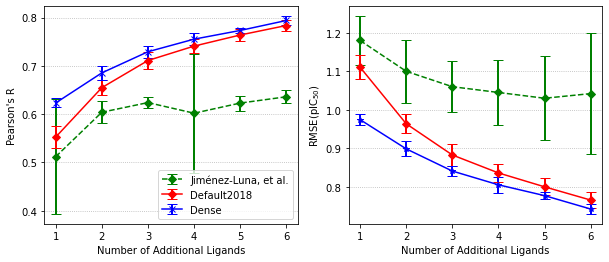

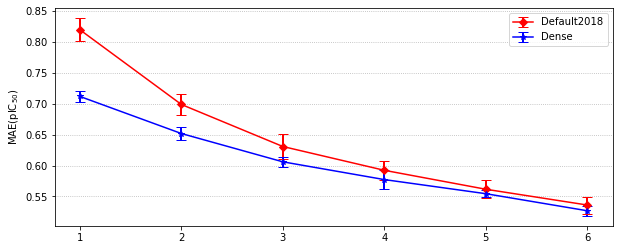

In [11]:
addnl_ligs_def2018['Addnl_Ligs'] = addnl_ligs_def2018['CSV_name'].apply(lambda x: int(x.split('/')[-1].split('.')[0].split('_')[-1]))
addnl_ligs_dense['Addnl_Ligs'] = addnl_ligs_dense['CSV_name'].apply(lambda x: int(x.split('/')[-1].split('.')[0].split('_')[-1]))
fig,axes = plt.subplots(1,2,figsize=(10,4))
# fig.add_subplot(121)
plt.axes(axes[0])
plt.errorbar(their_df['Addnl Ligs'],their_df['R'],yerr=their_df['R_std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.errorbar(addnl_ligs_def2018['Addnl_Ligs'],addnl_ligs_def2018['Avg_PearsonR'],yerr=addnl_ligs_def2018['Std_PearsonR'],label='Default2018',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.errorbar(addnl_ligs_dense['Addnl_Ligs'],addnl_ligs_dense['Avg_PearsonR'],yerr=addnl_ligs_dense['Std_PearsonR'],label='Dense',c='b',markeredgewidth=1,capsize=5,elinewidth=2,marker='x')
plt.xlabel('Number of Additional Ligands')
plt.ylabel(PR_lab)
plt.legend(loc='lower right')
ax = plt.gca()
ax.grid(axis='y',linestyle=':')
# fig.add_subplot(221)
plt.axes(axes[1])
plt.errorbar(their_df['Addnl Ligs'],their_df['RMSE'],yerr=their_df['RMSE_std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.errorbar(addnl_ligs_def2018['Addnl_Ligs'],addnl_ligs_def2018['Avg_RMSE'],yerr=addnl_ligs_def2018['Std_RMSE'],label='ours',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.errorbar(addnl_ligs_dense['Addnl_Ligs'],addnl_ligs_dense['Avg_RMSE'],yerr=addnl_ligs_dense['Std_RMSE'],label='Dense',c='b',markeredgewidth=1,capsize=5,elinewidth=2,marker='*')
plt.xlabel('Number of Additional Ligands')
plt.ylabel(RMSE_lab)
ax = plt.gca()
ax.grid(axis='y',linestyle=':')
plt.savefig('figs/paper_comparison_main.pdf',bbox_inches="tight")
plt.figure(figsize=(10,4))
plt.errorbar(addnl_ligs_def2018['Addnl_Ligs'],addnl_ligs_def2018['Avg_MAE'],yerr=addnl_ligs_def2018['Std_MAE'],label='Default2018',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.errorbar(addnl_ligs_dense['Addnl_Ligs'],addnl_ligs_dense['Avg_MAE'],yerr=addnl_ligs_dense['Std_MAE'],label='Dense',c='b',markeredgewidth=1,capsize=5,elinewidth=2,marker='*')
plt.ylabel(MAE_lab)
plt.legend()
ax = plt.gca()
ax.grid(axis='y',linestyle=':')
plt.savefig('figs/paper_comparison_mae.pdf')

# Ablation Study

In [57]:
ablated = ['noDDG','noDG','noRot','noCons','noDDG_noCons','noDG_noCons','Concat','NoSiam','combo','ConcatCombo']
ablation_study = build_graph(['models/addnl_ligs/def2018/statistics_1.csv']+[f'models/ablation/statistics_{abl}_1.csv' for abl in ablated])

In [58]:
ablation_study

,CSV_name,Avg_PearsonR,Avg_RMSE,Avg_MAE,Avg_Abs_PearsonR,Avg_Abs_RMSE,Avg_Abs_MAE,Std_PearsonR,Std_RMSE,Std_MAE,Std_Abs_PearsonR,Std_Abs_RMSE,Std_Abs_MAE
0,models/addnl_ligs/def2018/statistics_1.csv,0.552604,1.110560,0.819712,0.864032,0.840632,0.556012,0.023302,0.030937,0.018697,0.012390,0.037750,0.030285
1,models/ablation/statistics_noDDG_1.csv,0.551424,1.122000,0.828844,0.873104,0.814296,0.517024,0.020234,0.024783,0.017870,0.005695,0.018031,0.013592
2,models/ablation/statistics_noDG_1.csv,0.459012,1.271740,0.944888,0.027832,101.398608,100.966620,0.023756,0.028858,0.018245,0.107097,34.356581,34.503455
3,models/ablation/statistics_noRot_1.csv,0.555996,1.108440,0.819052,0.866248,0.833164,0.552544,0.018768,0.023273,0.016243,0.005904,0.016947,0.014078
4,models/ablation/statistics_noCons_1.csv,0.536428,1.138604,0.841756,0.866240,0.832556,0.558808,0.020997,0.035571,0.018636,0.005588,0.017131,0.015753
5,models/ablation/statistics_noDDG_noCons_1.csv,-0.057556,1.241520,0.908476,0.872964,0.813936,0.514372,0.135973,0.014318,0.014430,0.004250,0.013229,0.012050
6,models/ablation/statistics_noDG_noCons_1.csv,0.456404,1.276752,0.949708,-0.011832,6.648104,6.442196,0.023146,0.031897,0.023326,0.049432,0.464719,0.479720
7,models/ablation/statistics_Concat_1.csv,0.554364,1.110660,0.820776,0.869868,0.824284,0.530836,0.013441,0.022326,0.017384,0.004770,0.015513,0.015841
8,models/ablation/statistics_NoSiam_1.csv,0.500384,1.150380,0.854368,0.846268,0.883052,0.615904,0.034722,0.036192,0.021031,0.017474,0.047859,0.044158
9,models/ablation/statistics_combo_1.csv,0.511876,1.174988,0.876652,0.833848,0.919172,0.665716,0.021336,0.021327,0.015102,0.011091,0.023648,0.027019


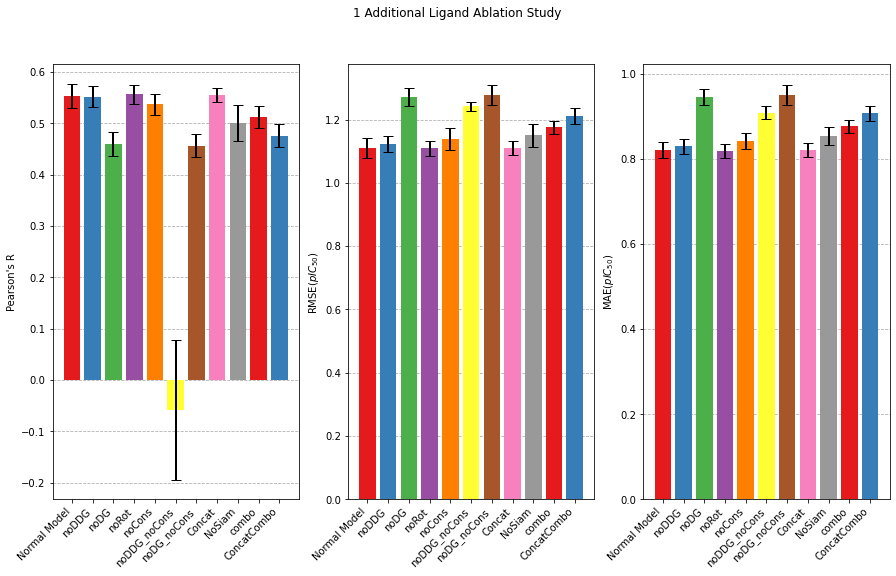

In [21]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set1.colors)
plt.figure(figsize=(15,8))
plt.subplot(131)
plt.bar(range(len(ablated)+1),ablation_study['Avg_PearsonR'],color=plt.cm.Set1.colors[:len(ablated)+1],tick_label=ablation_study.index,yerr=ablation_study['Std_PearsonR'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
# plt.bar(1,my_df['R'][0],tick_label='Normal Model',yerr=my_df['R_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(axis='y',linestyle='--')
ax.set_xticks(list(range(len(ablated)+1)))
ax.set_xticklabels(['Normal Model']+ablated,rotation=45,ha='right')
ax.set_ylabel("Pearson's R")
plt.subplot(132)
plt.bar(range(len(ablated)+1),ablation_study['Avg_RMSE'],color=plt.cm.Set1.colors[:len(ablated)+1],tick_label=ablation_study.index,yerr=ablation_study['Std_RMSE'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
# plt.bar(1,my_df['RMSE'][0],tick_label='Normal Model',yerr=my_df['RMSE_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
ax = plt.gca()
# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()
ax.set_axisbelow(True)
ax.grid(axis='y',linestyle='--')
ax.set_xticks(list(range(len(ablated)+1)))
ax.set_xticklabels(['Normal Model']+ablated,rotation=45,ha='right')
ax.set_ylabel(r"RMSE($pIC_{50}$)")
plt.subplot(133)
plt.bar(range(len(ablated)+1),ablation_study['Avg_MAE'],color=plt.cm.Set1.colors[:len(ablated)+1],tick_label=ablation_study.index,yerr=ablation_study['Std_MAE'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
# plt.bar(1,my_df['RMSE'][0],tick_label='Normal Model',yerr=my_df['RMSE_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
ax = plt.gca()
# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()
ax.set_axisbelow(True)
ax.grid(axis='y',linestyle='--')
ax.set_xticks(list(range(len(ablated)+1)))
ax.set_xticklabels(['Normal Model']+ablated,rotation=45,ha='right')
ax.set_ylabel(r"MAE($pIC_{50}$)")
plt.suptitle('1 Additional Ligand Ablation Study')
# plt.savefig('ablation_study.pdf',dpi=300,bbox_inches='tight')
plt.show()

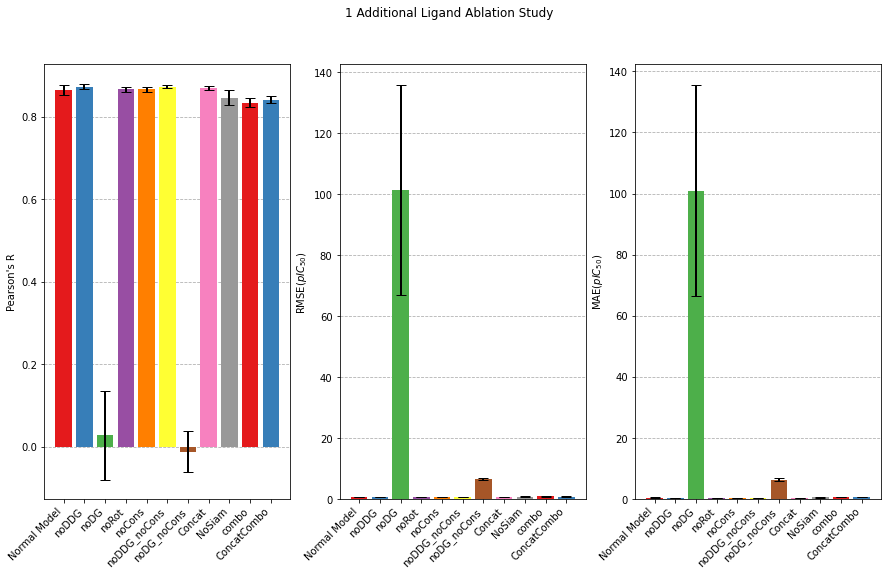

In [22]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set1.colors)
plt.figure(figsize=(15,8))
plt.subplot(131)
plt.bar(range(len(ablated)+1),ablation_study['Avg_Abs_PearsonR'],color=plt.cm.Set1.colors[:len(ablated)+1],tick_label=ablation_study.index,yerr=ablation_study['Std_Abs_PearsonR'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
# plt.bar(1,my_df['R'][0],tick_label='Normal Model',yerr=my_df['R_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(axis='y',linestyle='--')
ax.set_xticks(list(range(len(ablated)+1)))
ax.set_xticklabels(['Normal Model']+ablated,rotation=45,ha='right')
ax.set_ylabel("Pearson's R")
plt.subplot(132)
plt.bar(range(len(ablated)+1),ablation_study['Avg_Abs_RMSE'],color=plt.cm.Set1.colors[:len(ablated)+1],tick_label=ablation_study.index,yerr=ablation_study['Std_Abs_RMSE'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
# plt.bar(1,my_df['RMSE'][0],tick_label='Normal Model',yerr=my_df['RMSE_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
ax = plt.gca()
# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()
ax.set_axisbelow(True)
ax.grid(axis='y',linestyle='--')
ax.set_xticks(list(range(len(ablated)+1)))
ax.set_xticklabels(['Normal Model']+ablated,rotation=45,ha='right')
ax.set_ylabel(r"RMSE($pIC_{50}$)")
plt.subplot(133)
plt.bar(range(len(ablated)+1),ablation_study['Avg_Abs_MAE'],color=plt.cm.Set1.colors[:len(ablated)+1],tick_label=ablation_study.index,yerr=ablation_study['Std_Abs_MAE'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
# plt.bar(1,my_df['RMSE'][0],tick_label='Normal Model',yerr=my_df['RMSE_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
ax = plt.gca()
# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()
ax.set_axisbelow(True)
ax.grid(axis='y',linestyle='--')
ax.set_xticks(list(range(len(ablated)+1)))
ax.set_xticklabels(['Normal Model']+ablated,rotation=45,ha='right')
ax.set_ylabel(r"MAE($pIC_{50}$)")
plt.suptitle('1 Additional Ligand Ablation Study')
plt.show()

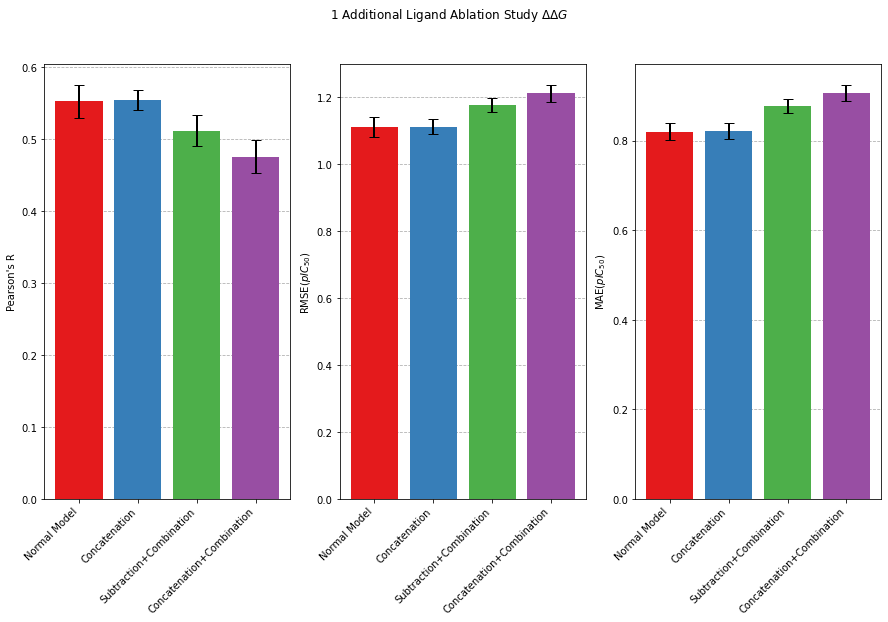

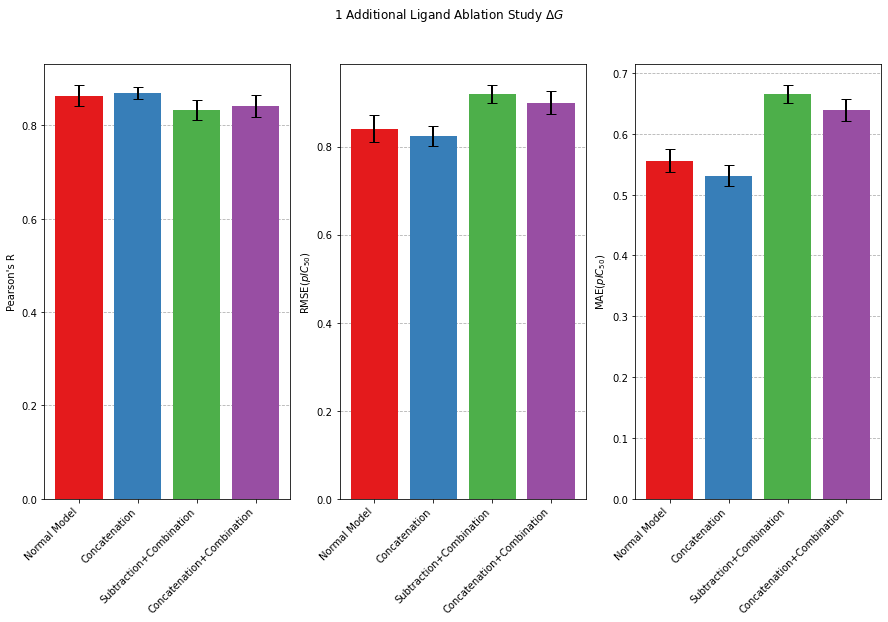

In [25]:
small_ablation_study = ablation_study[ablation_study['CSV_name'].isin(['models/addnl_ligs/def2018/statistics_1.csv',
                                                                 'models/ablation/statistics_Concat_1.csv',
                                                                 'models/ablation/statistics_combo_1.csv',
                                                                'models/ablation/statistics_ConcatCombo_1.csv'])]
ablated = ['Concatenation','Subtraction+Combination','Concatenation+Combination']
for figs in ['','_Abs']:
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set1.colors)
    plt.figure(figsize=(15,8))
    plt.subplot(131)
    plt.bar(range(len(ablated)+1),small_ablation_study[f'Avg{figs}_PearsonR'],color=plt.cm.Set1.colors[:len(ablated)+1],tick_label=small_ablation_study.index,yerr=small_ablation_study['Std_PearsonR'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
    # plt.bar(1,my_df['R'][0],tick_label='Normal Model',yerr=my_df['R_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
    ax = plt.gca()
    ax.set_axisbelow(True)
    ax.grid(axis='y',linestyle='--')
    ax.set_xticks(list(range(len(ablated)+1)))
    ax.set_xticklabels(['Normal Model']+ablated,rotation=45,ha='right')
    ax.set_ylabel(PR_lab)
    plt.subplot(132)
    plt.bar(range(len(ablated)+1),small_ablation_study[f'Avg{figs}_RMSE'],color=plt.cm.Set1.colors[:len(ablated)+1],tick_label=small_ablation_study.index,yerr=small_ablation_study['Std_RMSE'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
    # plt.bar(1,my_df['RMSE'][0],tick_label='Normal Model',yerr=my_df['RMSE_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
    ax = plt.gca()
    # ax.yaxis.set_label_position("right")
    # ax.yaxis.tick_right()
    ax.set_axisbelow(True)
    ax.grid(axis='y',linestyle='--')
    ax.set_xticks(list(range(len(ablated)+1)))
    ax.set_xticklabels(['Normal Model']+ablated,rotation=45,ha='right')
    ax.set_ylabel(RMSE_lab)
    plt.subplot(133)
    plt.bar(range(len(ablated)+1),small_ablation_study[f'Avg{figs}_MAE'],color=plt.cm.Set1.colors[:len(ablated)+1],tick_label=small_ablation_study.index,yerr=small_ablation_study['Std_MAE'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
    # plt.bar(1,my_df['RMSE'][0],tick_label='Normal Model',yerr=my_df['RMSE_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
    ax = plt.gca()
    # ax.yaxis.set_label_position("right")
    # ax.yaxis.tick_right()
    ax.set_axisbelow(True)
    ax.grid(axis='y',linestyle='--')
    ax.set_xticks(list(range(len(ablated)+1)))
    ax.set_xticklabels(['Normal Model']+ablated,rotation=45,ha='right')
    ax.set_ylabel(MAE_lab)
    if figs == '_Abs':
        plt.suptitle('1 Additional Ligand Ablation Study $\Delta G$')
        plt.savefig('figs/combo_study_dg.pdf',dpi=300,bbox_inches='tight')
    else:
        plt.suptitle('1 Additional Ligand Ablation Study $\Delta\Delta G$')
        plt.savefig('figs/combo_study_ddg.pdf',dpi=300,bbox_inches='tight')
    # plt.savefig('ablation_study.pdf',dpi=300,bbox_inches='tight')
    plt.show()

In [24]:
class LDataFrame(pd.DataFrame):
    def __init__(self, df):
        self.__class__ = type(df.__class__.__name__,
                              (self.__class__, df.__class__),
                              {})
        self.__dict__ = df.__dict__

    def to_latex(self,filename,header=None,toprow=None):
        with open(filename,'w') as f:
            f.write("\\begin{tabular}{|" + " | ".join(["c"] * len(self.columns)) + "|} \\hline \n")
            if toprow:
                for i, (mult, string) in enumerate(toprow):
                    if i > 0:
                        f.write(" &")
                    if mult > 1:
                        f.write("\\multicolumn{{{}}}{{c|}}{{{}}}".format(mult,string))
                    else:
                        f.write(string)
                f.write(" \\\\ \\hline \n")
            if header:
                f.write(" & ".join([str(x) for x in header]) + " \\\\ \\hline \n")
            for i, row in self.iterrows():
                f.write(" & ".join([str(x) for x in row.values]) + " \\\\ \\hline \n")
            f.write("\\end{tabular}")

In [27]:
ablation_table = ablation_study.copy()
for metric in base_statistics:
    ablation_table[f"{metric}"] = ablation_table[[f"Avg_{metric}",f"Std_{metric}"]].apply(lambda x: r"${:.3g}(\pm {:.3g})$".format(x[0],x[1]),axis=1)
ablation_table.drop([col for col in ablation_table.columns if ('Avg' in col) or ('Std' in col)],axis=1, inplace=True)
ablated = ['noDDG','noDG','noRot','noCons','noDDG_noCons','noDG_noCons','Concat','NoSiam','combo','ConcatCombo']
ablation_table['CSV_name'] = ["Standard","No $L_{\Delta\Delta G}$",
                              "No $L_{\Delta G}$","No $L_{\mathrm{Rotation}}$",
                              "No $L_{\mathrm{Consistency}}$","No $L_{\Delta\Delta G}$ \& $L_{\mathrm{Consistency}}$",
                              "No $L_{\Delta G}$ \& $L_{\mathrm{Consistency}}$",
                              "Concatenation","No Siamese Network","Subtraction \& Combinations","Concatentation \& Combinations"]
# LDataFrame(ablation_table).to_latex("ablation_table.tex",
#                         header=['Ablation',"Pearson's R","RMSE","MAE","Pearson's R","RMSE", "MAE"],
#                         toprow=[(1,''),(3,'Relative Binding Free Energy'),(3,'Absolute Binding Free Energy')]
#                        )
ablation_table[['CSV_name',"PearsonR","RMSE","MAE"]].to_latex("figs/ablation_table_NIPS.tex",
                       header=['Ablation',PR_lab,RMSE_lab,MAE_lab],
                        escape=False, index=False
                       )
ablation_table[['CSV_name',"Abs_PearsonR","Abs_RMSE","Abs_MAE"]].to_latex("figs/ablation_table_supp_NIPS.tex",
                       header=['Ablation',PR_lab,RMSE_lab,MAE_lab],
                        escape=False, index=False
                       )

In [28]:
ablation_table

,CSV_name,PearsonR,RMSE,MAE,Abs_PearsonR,Abs_RMSE,Abs_MAE
0,Standard,$0.553(\pm 0.0233)$,$1.11(\pm 0.0309)$,$0.82(\pm 0.0187)$,$0.864(\pm 0.0124)$,$0.841(\pm 0.0377)$,$0.556(\pm 0.0303)$
1,No $L_{\Delta\Delta G}$,$0.551(\pm 0.0202)$,$1.12(\pm 0.0248)$,$0.829(\pm 0.0179)$,$0.873(\pm 0.0057)$,$0.814(\pm 0.018)$,$0.517(\pm 0.0136)$
2,No $L_{\Delta G}$,$0.459(\pm 0.0238)$,$1.27(\pm 0.0289)$,$0.945(\pm 0.0182)$,$0.0278(\pm 0.107)$,$101(\pm 34.4)$,$101(\pm 34.5)$
3,No $L_{\mathrm{Rotation}}$,$0.556(\pm 0.0188)$,$1.11(\pm 0.0233)$,$0.819(\pm 0.0162)$,$0.866(\pm 0.0059)$,$0.833(\pm 0.0169)$,$0.553(\pm 0.0141)$
4,No $L_{\mathrm{Consistency}}$,$0.536(\pm 0.021)$,$1.14(\pm 0.0356)$,$0.842(\pm 0.0186)$,$0.866(\pm 0.00559)$,$0.833(\pm 0.0171)$,$0.559(\pm 0.0158)$
5,No $L_{\Delta\Delta G}$ \& $L_{\mathrm{Consist...,$-0.0576(\pm 0.136)$,$1.24(\pm 0.0143)$,$0.908(\pm 0.0144)$,$0.873(\pm 0.00425)$,$0.814(\pm 0.0132)$,$0.514(\pm 0.0121)$
6,No $L_{\Delta G}$ \& $L_{\mathrm{Consistency}}$,$0.456(\pm 0.0231)$,$1.28(\pm 0.0319)$,$0.95(\pm 0.0233)$,$-0.0118(\pm 0.0494)$,$6.65(\pm 0.465)$,$6.44(\pm 0.48)$
7,Concatenation,$0.554(\pm 0.0134)$,$1.11(\pm 0.0223)$,$0.821(\pm 0.0174)$,$0.87(\pm 0.00477)$,$0.824(\pm 0.0155)$,$0.531(\pm 0.0158)$
8,No Siamese Network,$0.5(\pm 0.0347)$,$1.15(\pm 0.0362)$,$0.854(\pm 0.021)$,$0.846(\pm 0.0175)$,$0.883(\pm 0.0479)$,$0.616(\pm 0.0442)$
9,Subtraction \& Combinations,$0.512(\pm 0.0213)$,$1.17(\pm 0.0213)$,$0.877(\pm 0.0151)$,$0.834(\pm 0.0111)$,$0.919(\pm 0.0236)$,$0.666(\pm 0.027)$


## Evaluate difference in performance when permutation vs combination train

In [29]:
from python_files.multtask_latent_def2018_concat_model import Net as ConcatNet
from python_files.multtask_latent_def2018_model import Net as SubtractNet
def evaluate_reverse(model_files,stats_save_name):
    stats_list=[]
    for model_file in model_files:
        print(model_file)
        if 'Concat' in model_file:
            Net = ConcatNet
        else:
            Net = SubtractNet
        
        test_data = molgrid.ExampleProvider(ligmolcache=f"cache/lig_full_bdb.molcache2",
                                        recmolcache=f"cache/rec_full_bdb.molcache2", 
                                    shuffle=True, duplicate_first=True, default_batch_size=16,
                                    iteration_scheme=molgrid.IterationScheme.LargeEpoch)
        testfile_num = model_file.split('.')[0].split('_')[-1]
        test_data.populate(f"new_Prot_Lig_Valid/all_data_test_papersplit_rand{testfile_num}_c_1.types")

        gmaker = molgrid.GridMaker()      
        dims = gmaker.grid_dimensions(14*4)  # only one rec+onelig per example      
        tensor_shape = (16,)+dims      

        args = Namespace(dropout=0,hidden_size=0)
        actual_dims = (dims[0]//2, *dims[1:])      
        model = Net(actual_dims,args).to('cuda')

        pretrained_state_dict = torch.load(model_file)      
        model_dict = model.state_dict()      
        pretrained_dict = {k: v for k, v in pretrained_state_dict.items() if k in model_dict}      
        model_dict.update(pretrained_dict)      
        model.load_state_dict(model_dict)
        
        input_tensor_1 = torch.zeros(tensor_shape, dtype=torch.float32, device='cuda')
        float_labels = torch.zeros(16, dtype=torch.float32)
        lig1_label = torch.zeros(16, dtype=torch.float32)
        lig2_label = torch.zeros(16, dtype=torch.float32)

        #running test loop
        model.eval()

        output_dist, output_dist_reverse, actual, actual_reverse = [], [], [], []
        lig_pred, lig_labels = [], []
        with torch.no_grad():
            for idx, batch in enumerate(test_data):        
                gmaker.forward(batch, input_tensor_1, random_translation=2.0, random_rotation=True) 
                batch.extract_label(1, float_labels)
                labels = torch.unsqueeze(float_labels, 1).float().to('cuda')
                batch.extract_label(2, lig1_label)
                batch.extract_label(3, lig2_label)
                lig1_labels = torch.unsqueeze(lig1_label, 1).float().to('cuda')
                lig2_labels = torch.unsqueeze(lig2_label, 1).float().to('cuda')
                output, lig1, lig2, _, _ = model(input_tensor_1[:, :28, :, :, :], input_tensor_1[:, 28:, :, :, :])
                output_reverse, lig1, lig2, _, _ = model(input_tensor_1[:, 28:, :, :, :], input_tensor_1[:, :28, :, :, :])
                lig_pred += lig1.flatten().tolist() + lig2.flatten().tolist()
                lig_labels += lig1_labels.flatten().tolist() + lig2_labels.flatten().tolist()
                output_dist += output.flatten().tolist()
                actual += labels.flatten().tolist()
                output_dist_reverse += output_reverse.flatten().tolist()
                actual_reverse += (-labels).flatten().tolist()
            
        r, rmse, mae = get_stats(0,output_dist,actual,lig_pred,lig_labels)
        r_full, rmse_full, mae_full = get_stats(0,output_dist+output_dist_reverse,actual+actual_reverse,lig_pred,lig_labels)
        
        stats_list.append([testfile_num,r[0],r_full[0],rmse[0],rmse_full[0], mae[0],mae_full[0],(np.array(output_dist)+np.array(output_dist_reverse)).mean()])
        
    final_stats = pd.DataFrame(stats_list,columns=['randval','PearsonR','R_Full','RMSE', 'RMSE_Full','MAE','MAE_Full','Avg Diff'])
    final_stats.to_csv(f"{stats_save_name}",index=False,float_format="%.4f")
    return final_stats

In [27]:
# final_stats = evaluate_reverse(glob('models/addnl_ligs/def2018/model_1_*.h5'),'models/ablation/everything_eval_perms.csv')
# final_stats_concat = evaluate_reverse(glob('models/ablation/model_Concat_1_*.h5'),'models/ablation/concat_eval_perms.csv')
final_stats_combo = evaluate_reverse(glob('models/ablation/model_combo_1_*.h5'),'models/ablation/everything_combo_eval_perms.csv')
final_stats_concatcombo = evaluate_reverse(glob('models/ablation/model_ConcatCombo_1_*.h5'),'models/ablation/concat_combo_eval_perms.csv')

models/ablation/model_combo_1_15.h5
27648
models/ablation/model_combo_1_10.h5
27648
models/ablation/model_combo_1_21.h5
27648
models/ablation/model_combo_1_8.h5
27648
models/ablation/model_combo_1_6.h5
27648
models/ablation/model_combo_1_9.h5
27648
models/ablation/model_combo_1_16.h5
27648
models/ablation/model_combo_1_2.h5
27648
models/ablation/model_combo_1_13.h5
27648
models/ablation/model_combo_1_17.h5
27648
models/ablation/model_combo_1_0.h5
27648
models/ablation/model_combo_1_4.h5
27648
models/ablation/model_combo_1_12.h5
27648
models/ablation/model_combo_1_19.h5
27648
models/ablation/model_combo_1_20.h5
27648
models/ablation/model_combo_1_22.h5
27648
models/ablation/model_combo_1_1.h5
27648
models/ablation/model_combo_1_18.h5
27648
models/ablation/model_combo_1_7.h5
27648
models/ablation/model_combo_1_5.h5
27648
models/ablation/model_combo_1_11.h5
27648
models/ablation/model_combo_1_14.h5
27648
models/ablation/model_combo_1_23.h5
27648
models/ablation/model_combo_1_3.h5
27648
mo

In [59]:
final_stats = pd.read_csv('models/ablation/everything_eval_perms.csv')
final_stats_concat = pd.read_csv('models/ablation/concat_eval_perms.csv')
final_stats_combo = pd.read_csv('models/ablation/everything_combo_eval_perms.csv')
final_stats_concatcombo = pd.read_csv('models/ablation/concat_combo_eval_perms.csv')

In [63]:
with open("figs/permute_vs_combo.tex","w") as pvc:
    pvc.write('\\begin{tabular}{l l} \n')
    pvc.write("\\toprule \n Ablation & Difference from Reverse Prediction ($\mathrm{pIC}_{50}$) \\\\ \\midrule \n")
    for evaluation,model_name in zip([final_stats,final_stats_combo,final_stats_concat,final_stats_concatcombo],['Normal Model','Subtraction \& Combinations','Concatenation','Concatenation \& Combinations']):
        pvc.write(f"\t {model_name} & {evaluation['Avg Diff'].mean():.4f} (\pm {evaluation['Avg Diff'].std():.4f}) \\\\ \n")
    pvc.write("\\bottomrule \n \\end{tabular}")
# print('{:.4f} & {:.4f} & {:.4f} & {:.4f} \\\\'.format(final_stats['Avg Diff'].mean(),final_stats_concat['Avg Diff'].mean(),final_stats_combo['Avg Diff'].mean(),final_stats_concatcombo['Avg Diff'].mean()))
# print('{:.4f} & {:.4f} & {:.4f} & {:.4f} \\\\'.format(final_stats['Avg Diff'].std(),final_stats_concat['Avg Diff'].std(),final_stats_combo['Avg Diff'].std(),final_stats_concatcombo['Avg Diff'].std()))

# Evaluate Absolute Affinity Prediction

In [167]:
from python_files.default2018_single_model import Net
def eval_abs_pred(model_files):
    stats_list=[]
    test_data = molgrid.ExampleProvider(data_root='/home/anm329/Docking/refined_set_input', 
                                    shuffle=True, default_batch_size=32,
                                    iteration_scheme=molgrid.IterationScheme.LargeEpoch)
    testfile_num = model_file.split('/')[-1].split('.')[0].split('_')[-1]
    test_data.populate(f"/home/anm329/Docking/core_not_ddg.types")

    gmaker = molgrid.GridMaker()      
    dims = gmaker.grid_dimensions(14*2)  # only one rec+onelig per example      
    tensor_shape = (32,)+dims      

    args = Namespace(dropout=0,hidden_size=0)   
    model = Net(dims,args).to('cuda')
    for idx,model_file in enumerate(model_files):
        print(idx)
        

        pretrained_state_dict = torch.load(model_file)      
        model_dict = model.state_dict()
        pretrained_state_dict['last_fc.weight']=pretrained_state_dict['affinity.weight']
        pretrained_state_dict['last_fc.bias']=pretrained_state_dict['affinity.bias']
        pretrained_dict = {k: v for k, v in pretrained_state_dict.items() if k in model_dict}
#         print(pretrained_dict.keys())
        model_dict.update(pretrained_dict)      
        load_info = model.load_state_dict(model_dict)
#         print(load_info)
        
        input_tensor_1 = torch.zeros(tensor_shape, dtype=torch.float32, device='cuda')
        float_labels = torch.zeros(32, dtype=torch.float32)

        #running test loop
        model.eval()

        output_dist, output_dist_reverse, actual, actual_reverse = [], [], [], []
        lig_pred, lig_labels = [], []
        with torch.no_grad():
            for idx, batch in enumerate(test_data):        
                gmaker.forward(batch, input_tensor_1, random_translation=2.0, random_rotation=True) 
                batch.extract_label(0, float_labels)
                labels = torch.unsqueeze(float_labels, 1).float().to('cuda')
                output = model(input_tensor_1)
                output_dist += output.flatten().tolist()
                actual += labels.flatten().tolist()
            
        r, rmse, mae = get_stats(0,output_dist,actual,lig_pred,lig_labels)
        
        stats_list.append([testfile_num,r[0],rmse[0], mae[0]])
        
        
    return pd.DataFrame(stats_list,columns=['randval','PearsonR','RMSE','MAE'])

In [185]:
def eval_gnina_cnns(affinities_list):
    stats_list = []
    actual = pd.read_csv("/home/anm329/Docking/core_not_ddg.types",sep=' ',header=None)
    for affinities in affinities_list:
        affs = pd.read_csv(affinities,header=None,sep=' ')[0].astype(float).tolist()
        r, rmse, mae = get_stats(0,[],[],affs,actual[0].to_list())
        stats_list.append([r[1],rmse[1],mae[1]])
    return pd.DataFrame(stats_list,columns=['PearsonR','RMSE','MAE']) 

In [186]:
crossdock_default2018_stats = eval_gnina_cnns(glob('models/crossdock_default2018*_affinities.txt'))
general_default2018_stats = eval_gnina_cnns(glob('models/general_default2018*_affinities.txt'))
redock_default2018_stats = eval_gnina_cnns(glob('models/redock_default2018*_affinities.txt'))
crossdock_default2018_stats.to_csv('models/crossdock_default2018_statistics.csv')
redock_default2018_stats.to_csv('models/redock_default2018_statistics.csv')
general_default2018_stats.to_csv('models/general_default2018_statistics.csv')

0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.


<ipython-input-83-1e34f3aeba5a>:14: RuntimeWarning: Mean of empty slice.
  rmse_ddg = np.sqrt(((np.array(pred_ddg)-np.array(actual_ddg)) ** 2).mean())
<ipython-input-83-1e34f3aeba5a>:18: RuntimeWarning: Mean of empty slice.
  mae = (np.abs(np.array(pred_ddg)-np.array(actual_ddg)).mean(),


#### Downloading Def2018 models trained on all BDB data

In [164]:
model="multtask_latent_def2018"
weight_decay=0
ddg_weight=10
consistency_weight=1
absolute_weight=1
rotation_weight=1
use_weights=None
model_save_path = 'models/fullTrain/def2018/'
spec_name=''
runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
                       filters={"$and":[{"config.use_model":model},{'tags':f'TrainAllPerms'},
                                        {"config.rot_warmup":0},{"config.weight_decay":weight_decay},
                                        {"config.solver":"adam"},{"config.ddg_loss_weight":ddg_weight},
                                        {"config.consistency_loss_weight":consistency_weight},
                                        {"config.absolute_loss_weight":absolute_weight},
                                        {"config.rotation_loss_weight":rotation_weight},
                                        {"config.use_weights":use_weights},
                                        {"state":"finished"}]})
for randval, run in enumerate(runs):
    if not os.path.isfile(f"{model_save_path}model{spec_name}_{randval}.h5"):
            run.file('model.h5').download(root=model_save_path)
            os.rename(f"{model_save_path}model.h5",f"{model_save_path}model{spec_name}_{randval}.h5")

In [168]:
full_train = eval_abs_pred(glob('models/fullTrain/def2018/model_*.h5'))
full_train.to_csv('models/fullTrain/def2018/statistics_absaff.csv')

27648
dict_keys(['unit1_conv.weight', 'unit1_conv.bias', 'unit2_conv.weight', 'unit2_conv.bias', 'unit3_conv.weight', 'unit3_conv.bias', 'unit4_conv.weight', 'unit4_conv.bias', 'unit5_conv.weight', 'unit5_conv.bias', 'last_fc.weight', 'last_fc.bias'])
0:x and y must have length at least 2.
27648
dict_keys(['unit1_conv.weight', 'unit1_conv.bias', 'unit2_conv.weight', 'unit2_conv.bias', 'unit3_conv.weight', 'unit3_conv.bias', 'unit4_conv.weight', 'unit4_conv.bias', 'unit5_conv.weight', 'unit5_conv.bias', 'last_fc.weight', 'last_fc.bias'])


<ipython-input-83-1e34f3aeba5a>:15: RuntimeWarning: Mean of empty slice.
  rmse_abs = np.sqrt(((np.array(pred_abs)-np.array(actual_abs)) ** 2).mean())
<ipython-input-83-1e34f3aeba5a>:19: RuntimeWarning: Mean of empty slice.
  np.abs(np.array(pred_abs)-np.array(actual_abs)).mean())


0:x and y must have length at least 2.
27648
dict_keys(['unit1_conv.weight', 'unit1_conv.bias', 'unit2_conv.weight', 'unit2_conv.bias', 'unit3_conv.weight', 'unit3_conv.bias', 'unit4_conv.weight', 'unit4_conv.bias', 'unit5_conv.weight', 'unit5_conv.bias', 'last_fc.weight', 'last_fc.bias'])
0:x and y must have length at least 2.
27648
dict_keys(['unit1_conv.weight', 'unit1_conv.bias', 'unit2_conv.weight', 'unit2_conv.bias', 'unit3_conv.weight', 'unit3_conv.bias', 'unit4_conv.weight', 'unit4_conv.bias', 'unit5_conv.weight', 'unit5_conv.bias', 'last_fc.weight', 'last_fc.bias'])
0:x and y must have length at least 2.
27648
dict_keys(['unit1_conv.weight', 'unit1_conv.bias', 'unit2_conv.weight', 'unit2_conv.bias', 'unit3_conv.weight', 'unit3_conv.bias', 'unit4_conv.weight', 'unit4_conv.bias', 'unit5_conv.weight', 'unit5_conv.bias', 'last_fc.weight', 'last_fc.bias'])
0:x and y must have length at least 2.
27648
dict_keys(['unit1_conv.weight', 'unit1_conv.bias', 'unit2_conv.weight', 'unit2_con

In [178]:
base_statistics = ['PearsonR','RMSE','MAE']
avg_std_base_statistics = [f'Avg_{base}' for base in base_statistics] + [f'Std_{base}' for base in base_statistics]
def build_abs_graph(list_csvs):
    stats_list = []
    for csv in list_csvs:
        data = pd.read_csv(csv)
        avgs = data[base_statistics].mean(axis=0)
        stds = data[base_statistics].std(axis=0)
        stats_list.append([csv] + avgs.values.tolist()+stds.values.tolist())
#     print(stats_list)
    return pd.DataFrame(stats_list,columns=['CSV_name']+avg_std_base_statistics)

In [187]:
absolute_affinity_comparisons = build_abs_graph(['models/fullTrain/def2018/statistics_absaff.csv']+[f'models/{dset}_default2018_statistics.csv' for dset in ['redock','crossdock','general']])

In [200]:
absolute_affinity_comparisons.index = absolute_affinity_comparisons['CSV_name'].apply(
    lambda x: x.split('/')[-1].split('.')[0].replace('_statistics','').replace('_',' ').title())

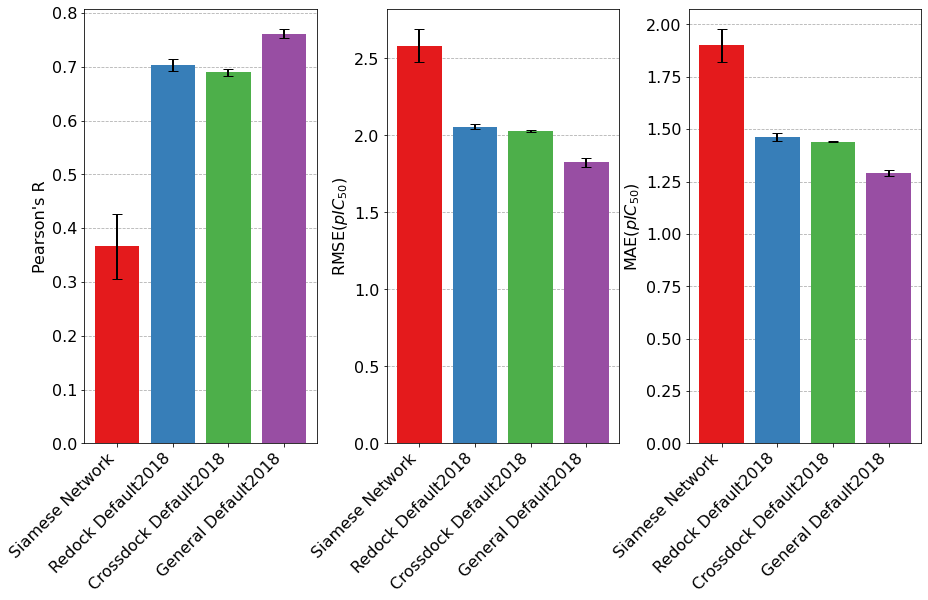

In [226]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set1.colors)
fig = plt.figure(figsize=(15,8),subplotpars=matplotlib.figure.SubplotParams(wspace=0.3))
plt.subplot(131)
plt.bar(range(len(absolute_affinity_comparisons)),absolute_affinity_comparisons['Avg_PearsonR'],color=plt.cm.Set1.colors[:len(absolute_affinity_comparisons)+1],tick_label=absolute_affinity_comparisons.index,yerr=absolute_affinity_comparisons['Std_PearsonR'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
# plt.bar(1,my_df['R'][0],tick_label='Normal Model',yerr=my_df['R_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(axis='y',linestyle='--')
ax.set_xticks(list(range(len(absolute_affinity_comparisons))))
ax.set_xticklabels(['Siamese Network'] + absolute_affinity_comparisons.index[1:].tolist(),rotation=45,ha='right')
ax.set_ylabel("Pearson's R")
plt.subplot(132)
plt.bar(range(len(absolute_affinity_comparisons)),absolute_affinity_comparisons['Avg_RMSE'],color=plt.cm.Set1.colors[:len(absolute_affinity_comparisons)+1],tick_label=absolute_affinity_comparisons.index,yerr=absolute_affinity_comparisons['Std_RMSE'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
# plt.bar(1,my_df['RMSE'][0],tick_label='Normal Model',yerr=my_df['RMSE_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
ax = plt.gca()
# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()
ax.set_axisbelow(True)
ax.grid(axis='y',linestyle='--')
ax.set_xticks(list(range(len(absolute_affinity_comparisons))))
ax.set_xticklabels(['Siamese Network'] + absolute_affinity_comparisons.index[1:].tolist(),rotation=45,ha='right')
ax.set_ylabel(r"RMSE($pIC_{50}$)")
plt.subplot(133)
plt.bar(range(len(absolute_affinity_comparisons)),absolute_affinity_comparisons['Avg_MAE'],color=plt.cm.Set1.colors[:len(absolute_affinity_comparisons)],tick_label=absolute_affinity_comparisons.index,yerr=absolute_affinity_comparisons['Std_MAE'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
# plt.bar(1,my_df['RMSE'][0],tick_label='Normal Model',yerr=my_df['RMSE_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
ax = plt.gca()
# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()
ax.set_axisbelow(True)
ax.grid(axis='y',linestyle='--')
ax.set_xticks(list(range(len(absolute_affinity_comparisons))))
ax.set_xticklabels(['Siamese Network'] + absolute_affinity_comparisons.index[1:].tolist(),rotation=45,ha='right')
ax.set_ylabel(r"MAE($pIC_{50}$)")
# plt.suptitle('Absolute Affinity Prediction')
plt.savefig('figs/absolute_affinity_comparison.pdf',bbox_inches='tight')

# Evaluating LOO-PFAM

# First pure No-shot

In [163]:
model="multtask_latent_def2018"
weight_decay=0
ddg_weight=10
consistency_weight=1
absolute_weight=1
rotation_weight=1
use_weights=None
model_save_path = 'models/LOO-PFAM/def2018/'
spec_name=''
loopfam_runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
                       filters={"$and":[{"config.use_model":model},{'tags':f'BASE_PFAM'},
                                        {"config.rot_warmup":0},{"config.weight_decay":weight_decay},
                                        {"config.solver":"adam"},{"config.ddg_loss_weight":ddg_weight},
                                        {"config.consistency_loss_weight":consistency_weight},
                                        {"config.absolute_loss_weight":absolute_weight},
                                        {"config.rotation_loss_weight":rotation_weight},
                                        {"config.use_weights":use_weights},
                                        {"$or":[{"state":"finished"},{"state":"running"}]}]})
print(len(loopfam_runs))

73


In [310]:
def create_stats_loo_pfam(model_save_path,runs):
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)
    rands = []
    stats_list = []
    predictions = []
    actual = []
    for run in runs:
        saved_tag = ''
        if run.state != 'finished':
            continue
        testfile = run.config['testfile'].split('/')[-1].split('.')[0]
        saved_tag = list(map(int,re.findall(r'\d+',testfile)))[0]
        print(saved_tag)
        
        if saved_tag > 71:
            continue
        # assert saved_tag < len(runs), f"{run.tags}_{run}"
        if not os.path.isfile(f"{model_save_path}model_{saved_tag}.h5"):
            run.file('model.h5').download(root=model_save_path)
            os.rename(f"{model_save_path}model.h5",f"{model_save_path}model_{saved_tag}.h5")

        config = Namespace()
        for k,v in run.config.items():
            setattr(config,k,v)

        r,rmse, mae, vals = get_eval(config,f"{model_save_path}model_{saved_tag}.h5",return_vals=True)
        # print(saved_tag,r,rmse,mae)
        stats_list.append([saved_tag,len(vals[0]),r[0],rmse[0],mae[0],r[1],rmse[1],mae[1]])
        predictions += vals[0]
        actual += vals[1]
        
        
    final_stats = pd.DataFrame(stats_list,columns=['PFAM','Test Size','PearsonR','RMSE','MAE','Abs_PearsonR','Abs_RMSE','Abs_MAE'])
    final_stats.to_csv(f"{model_save_path}statistics.csv",index=False,float_format="%.4f")
    
    return final_stats, (predictions, actual)

In [333]:
loo_pfam_stats, LOO_PFAM_pred_act = create_stats_loo_pfam('models/LOO-PFAM/def2018/',loopfam_runs)

71
27648
70
27648
69
27648
68
27648
72
54
27648
52
27648
53
27648
55
27648
59
27648
58
27648
57
27648
56
27648
62
27648
61
27648
60
27648
63
27648
64
27648
66
27648
65
27648
67
27648
50
27648
51
27648
46
27648
42
27648
40
27648
47
27648
45
27648
41
27648
43
27648
44
27648
34
27648
39
27648


KeyboardInterrupt: 

In [334]:
pfam_mapping = pd.read_table('new_Prot_Lig_Valid/pfam_values_map.txt',sep=' ').to_dict('index')
loo_pfam_stats['pfam'] = loo_pfam_stats['PFAM'].apply(lambda x: pfam_mapping[x]['Test_PFAM'])

In [335]:
loo_pfam_stats


,PFAM,Test Size,PearsonR,RMSE,MAE,Abs_PearsonR,Abs_RMSE,Abs_MAE,pfam
pfam,,,,,,,,,
An_peroxidase,71,16,0.133106,0.642456,0.536999,0.108659,2.006540,1.944623,An_peroxidase
IDO,70,144,0.209870,1.373714,1.124882,0.217502,1.149668,0.971379,IDO
Peptidase_S28,69,16,0.956838,0.831166,0.818412,0.901322,0.471002,0.399563,Peptidase_S28
AMP-binding,68,224,-0.368301,1.114301,0.887118,-0.296884,0.935003,0.781873,AMP-binding
DAO,54,224,0.407573,1.407634,1.091431,0.173471,1.430709,1.264856,DAO
...,...,...,...,...,...,...,...,...,...
polyprenyl_synt,17,48,-0.085493,1.282444,1.112260,0.347564,3.051938,2.787571,polyprenyl_synt
adh_short_C2,19,960,0.200557,1.364685,1.090126,0.126146,1.478048,1.214269,adh_short_C2
2OG-FeII_Oxy_3,18,48,0.874914,0.973517,0.612077,0.836214,0.630410,0.484375,2OG-FeII_Oxy_3


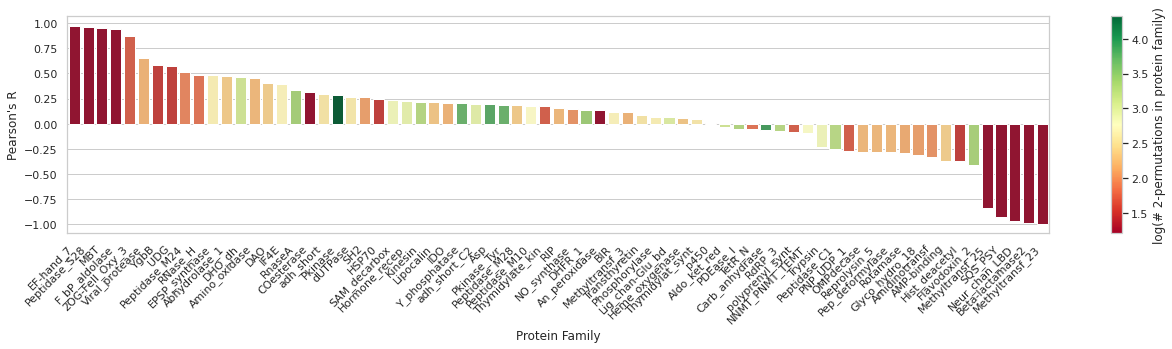

In [336]:
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
sorted_loopfam = loo_pfam_stats.sort_values(['PearsonR'],ascending=False)
sns.set(rc={"figure.figsize":(22, 4)})
sns.set_theme(style="whitegrid")
norm = plt.Normalize(vmin=np.log10(sorted_loopfam['Test Size'].min()), vmax=np.log10(sorted_loopfam['Test Size'].max()))
colors = [plt.cm.RdYlGn(norm(np.log10(c))) for c in sorted_loopfam['Test Size']]
chart = sns.barplot(x='pfam',y='PearsonR',data=sorted_loopfam,palette=colors)
_ = chart.set_xticklabels(labels=chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_ylabel("Pearson's R")
chart.set_xlabel("Protein Family")

# norm = plt.Normalize(sorted_loopfam['Test Size'].min(), sorted_loopfam['Test Size'].max())
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
sm.set_array([])

# chart.get_legend().remove()
chart.figure.colorbar(sm,label="log(# 2-permutations in protein family)")
plt.savefig('figs/LOO_pfam_R_NeurIPS.pdf',bbox_inches="tight")

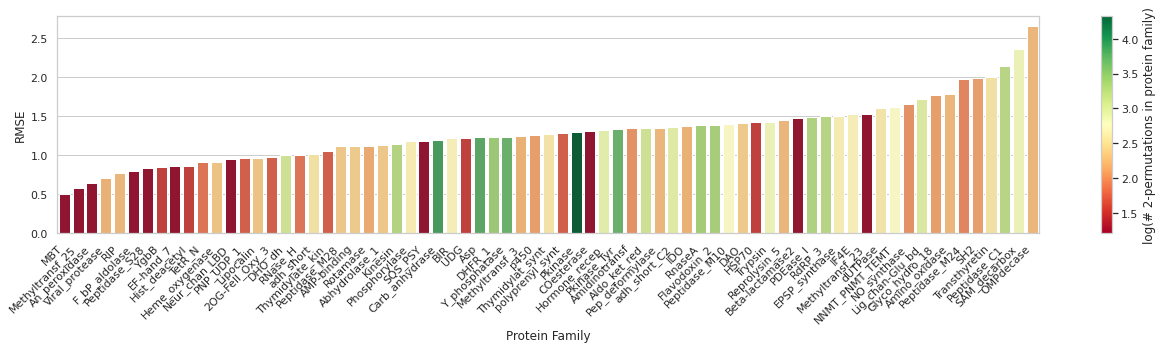

In [338]:
sorted_loopfam = loo_pfam_stats.sort_values(['RMSE'])
sns.set(rc={"figure.figsize":(22, 4)})
sns.set_theme(style="whitegrid")
norm = plt.Normalize(vmin=np.log10(sorted_loopfam['Test Size'].min()), vmax=np.log10(sorted_loopfam['Test Size'].max()))
colors = [plt.cm.RdYlGn(norm(np.log10(c))) for c in sorted_loopfam['Test Size']]
chart = sns.barplot(x='pfam',y='RMSE',data=sorted_loopfam,palette=colors)
_ = chart.set_xticklabels(labels=chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_ylabel("RMSE")
chart.set_xlabel("Protein Family")

# norm = plt.Normalize(sorted_loopfam['Test Size'].min(), sorted_loopfam['Test Size'].max())
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
sm.set_array([])

# chart.get_legend().remove()
chart.figure.colorbar(sm,label="log(# 2-permutations in protein family)")
plt.savefig('figs/LOO_pfam_RMSE_NeurIPS.pdf',bbox_inches="tight")

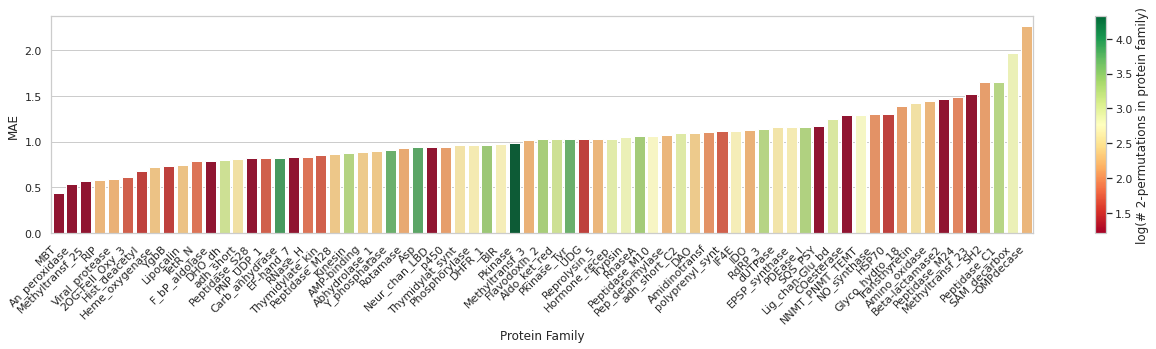

In [339]:
sorted_loopfam = loo_pfam_stats.sort_values(['MAE'])
sns.set(rc={"figure.figsize":(22, 4)})
sns.set_theme(style="whitegrid")
norm = plt.Normalize(vmin=np.log10(sorted_loopfam['Test Size'].min()), vmax=np.log10(sorted_loopfam['Test Size'].max()))
colors = [plt.cm.RdYlGn(norm(np.log10(c))) for c in sorted_loopfam['Test Size']]
chart = sns.barplot(x='pfam',y='MAE',data=sorted_loopfam,palette=colors)
_ = chart.set_xticklabels(labels=chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_ylabel("MAE")
chart.set_xlabel("Protein Family")

# norm = plt.Normalize(sorted_loopfam['Test Size'].min(), sorted_loopfam['Test Size'].max())
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
sm.set_array([])

# chart.get_legend().remove()
chart.figure.colorbar(sm,label="log(# 2-permutations in protein family)")
plt.savefig('figs/LOO_pfam_MAE_NeurIPS.pdf',bbox_inches="tight")

In [340]:
print(get_stats(0,LOO_PFAM_pred_act[0],LOO_PFAM_pred_act[1],[],[]))
print("mean:",loo_pfam_stats.mean())
print("min:",loo_pfam_stats.min())
print("max:",loo_pfam_stats.max())

0:x and y must have length at least 2.
((0.15807414406975276, nan), (1.3477985978235631, nan), (1.0095416629288465, nan))
mean: PFAM              35.676056
Test Size       1069.070423
PearsonR           0.097755
RMSE               1.290232
MAE                1.041151
Abs_PearsonR       0.081479
Abs_RMSE           1.688056
Abs_MAE            1.463263
dtype: float64
min: PFAM                         0
Test Size                   16
PearsonR              -0.99248
RMSE                  0.499045
MAE                   0.444593
Abs_PearsonR         -0.968901
Abs_RMSE              0.471002
Abs_MAE               0.399563
pfam            2OG-FeII_Oxy_3
dtype: object
max: PFAM                         71
Test Size                 21216
PearsonR               0.972355
RMSE                   2.643728
MAE                    2.253479
Abs_PearsonR           0.901322
Abs_RMSE               4.426863
Abs_MAE                4.364258
pfam            polyprenyl_synt
dtype: object


<ipython-input-218-e7206f513fb7>:15: RuntimeWarning: Mean of empty slice.
  rmse_abs = np.sqrt(((np.array(pred_abs)-np.array(actual_abs)) ** 2).mean())
/home/anm329/anaconda3/envs/py38_torch/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-218-e7206f513fb7>:19: RuntimeWarning: Mean of empty slice.
  np.abs(np.array(pred_abs)-np.array(actual_abs)).mean())


# No shot and Few-Shot

In [315]:
ns_runs[0]

<Run andmcnutt/DDG_model_Regression/g41p5z0o (finished)>

In [316]:
model="multtask_latent_def2018"
weight_decay=0
ddg_weight=10
consistency_weight=1
absolute_weight=1
rotation_weight=1
use_weights=None
stratify_rec = False
ns_runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
                       filters={"$and":[{"config.use_model":model},{'tags':f'CV_add_0'},{'tags':f'fixed'},
                                        {"config.rot_warmup":0},{"config.weight_decay":weight_decay},
                                        {"config.solver":"adam"},{"config.ddg_loss_weight":ddg_weight},
                                        {"config.consistency_loss_weight":consistency_weight},
                                        {"config.stratify_rec":stratify_rec},
                                        {"config.absolute_loss_weight":absolute_weight},
                                        {"config.rotation_loss_weight":rotation_weight},
                                        {"config.use_weights":use_weights},
                                        {"state":"finished"}]})
print(f"no_shot {len(ns_runs)}")
ns_stats, ns_pred_act = create_stats_loo_pfam('models/LOO-PFAM_fewshot/noshot/',ns_runs)
fs2_runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
                       filters={"$and":[{"config.use_model":model},{'tags':f'CV_add_2'},{'tags':f'fixed'},
                                        {"config.rot_warmup":0},{"config.weight_decay":weight_decay},
                                        {"config.solver":"adam"},{"config.ddg_loss_weight":ddg_weight},
                                        {"config.consistency_loss_weight":consistency_weight},
                                        {"config.stratify_rec":stratify_rec},
                                        {"config.absolute_loss_weight":absolute_weight},
                                        {"config.rotation_loss_weight":rotation_weight},
                                        {"config.use_weights":use_weights},
                                        {"state":"finished"}]})
print(f"fs2 {len(fs2_runs)}")
fs2_stats, fs2_pred_act = create_stats_loo_pfam('models/LOO-PFAM_fewshot/fs2/',fs2_runs)
fs4_runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
                       filters={"$and":[{"config.use_model":model},{'tags':f'CV_add_4'},{'tags':f'fixed'},
                                        {"config.rot_warmup":0},{"config.weight_decay":weight_decay},
                                        {"config.solver":"adam"},{"config.ddg_loss_weight":ddg_weight},
                                        {"config.consistency_loss_weight":consistency_weight},
                                        {"config.stratify_rec":stratify_rec},
                                        {"config.absolute_loss_weight":absolute_weight},
                                        {"config.rotation_loss_weight":rotation_weight},
                                        {"config.use_weights":use_weights},
                                        {"state":"finished"}]})
print(f"fs4 {len(fs4_runs)}")
fs4_stats, fs4_pred_act = create_stats_loo_pfam('models/LOO-PFAM_fewshot/fs4/',fs4_runs)
fs6_runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
                       filters={"$and":[{"config.use_model":model},{'tags':f'CV_add_6'},{'tags':f'fixed'},
                                        {"config.rot_warmup":0},{"config.weight_decay":weight_decay},
                                        {"config.solver":"adam"},{"config.ddg_loss_weight":ddg_weight},
                                        {"config.consistency_loss_weight":consistency_weight},
                                        {"config.stratify_rec":stratify_rec},
                                        {"config.absolute_loss_weight":absolute_weight},
                                        {"config.rotation_loss_weight":rotation_weight},
                                        {"config.use_weights":use_weights},
                                        {"state":"finished"}]})
print(f"fs6 {len(fs6_runs)}")
fs6_stats, fs6_pred_act = create_stats_loo_pfam('models/LOO-PFAM_fewshot/fs6/',fs6_runs)

no_shot 60
11
27648
70
27648
68
27648
66
27648
59
27648
58
27648
60
27648
63
27648
62
27648
65
27648
64
27648
52
27648
53
27648
54
27648
55
27648
36
27648
35
27648
42
27648
37
27648
33
27648
39
27648
38
27648
34
27648
16
27648
9
27648
14
27648
10
27648
13
27648
15
27648
3
27648
2
27648
1
27648
0
27648
46
27648
51
27648
8
27648
56
27648
45
27648
7
27648
50
27648
44
27648
5
27648
6
27648
4
27648
43
27648
49
27648
48
27648
17
27648
20
27648
18
27648
24
27648
27
27648
25
27648
29
27648
19
27648
28
27648
31
27648
26
27648
30
27648
23
27648
fs2 60
68
27648
70
27648
66
27648
65
27648
63
27648
64
27648
23
27648
10
27648
48
27648
50
27648
7
27648
52
27648
60
27648
3
27648
13
27648
2
27648
45
27648
17
27648
59
27648
20
27648
46
27648
54
27648
24
27648
0
27648
15
27648
27
27648
44
27648
16
27648
56
27648
25
27648
55
27648
19
27648
53
27648
9
27648
62
27648
26
27648
1
27648
6
27648
49
27648
4
27648
5
27648
51
27648
11
27648
28
27648
58
27648
8
27648
14
27648
18
27648
31
27648
36
27648
38
27648
43


In [317]:
print([len(stats) for stats in [ns_stats,fs2_stats,fs4_stats,fs6_stats]])

[60, 60, 60, 60]


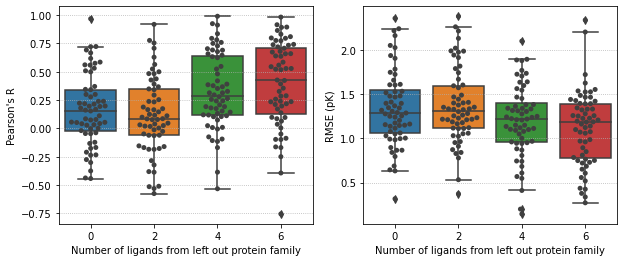

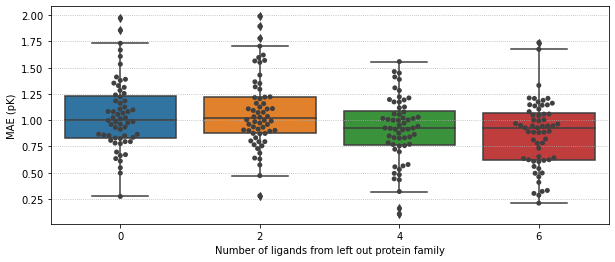

In [318]:
fig,axes = plt.subplots(1,2,figsize=(10,4))
# fig.add_subplot(121)
plt.axes(axes[0])
full_PearsonR = pd.DataFrame([ns_stats['PearsonR'],fs2_stats['PearsonR'],fs4_stats['PearsonR'],fs6_stats['PearsonR']]).T
full_PearsonR.columns=['0','2','4','6']
sns.boxplot(data=full_PearsonR)
sns.swarmplot(data=full_PearsonR, color=".25")
plt.xlabel('Number of ligands from left out protein family')
plt.ylabel(PR_lab)
ax = plt.gca()
ax.grid(axis='y',linestyle=':')
# fig.add_subplot(221)
plt.axes(axes[1])
full_RMSE = pd.DataFrame([ns_stats['RMSE'],fs2_stats['RMSE'],fs4_stats['RMSE'],fs6_stats['RMSE']]).T
full_RMSE.columns=['0','2','4','6']
sns.boxplot(data=full_RMSE)
sns.swarmplot(data=full_RMSE, color=".25")
plt.xlabel('Number of ligands from left out protein family')
plt.ylabel(RMSE_lab)
ax = plt.gca()
ax.grid(axis='y',linestyle=':')
plt.savefig('figs/loo-pfam-fs.pdf',bbox_inches="tight")
plt.figure(figsize=(10,4))
full_MAE = pd.DataFrame([ns_stats['MAE'],fs2_stats['MAE'],fs4_stats['MAE'],fs6_stats['MAE']]).T
full_MAE.columns=['0','2','4','6']
sns.boxplot(data=full_MAE)
sns.swarmplot(data=full_MAE, color=".25")
plt.xlabel('Number of ligands from left out protein family')
plt.ylabel(MAE_lab)
ax = plt.gca()
ax.grid(axis='y',linestyle=':')
plt.savefig('figs/loo-pfam-mae.pdf')

# Evaluating External Finetune

In [319]:
def create_external_stats(model_save_path,num_runs = 25,model="multtask_latent_def2018",
                 num_addnl=1,weight_decay=0,ddg_weight=10,consistency_weight=1,
                absolute_weight=1,rotation_weight=1,use_weights=None,spec_name='',
                 rot_warmup=0,state="finished",tag='MseLoss',dset=None):
    runs = glob(f'{model_save_path}*_{spec_name}.h5')
    assert len(runs) == num_runs, f"only have {len(runs)} runs"
    rands = []
    stats_list = []
    for idx, run in enumerate(sorted(runs)):
        print(run)
        rand = run.split('/')[-1].split('_')[1]
        randval = int(rand.replace('rand',''))
        # else:
        #     rand = run.split('/')[-1].split('.')[0].split('_')[2]
        #     randval = int(rand.replace('rand',''))

        rands.append(randval)

        if dset:
            config = Namespace(testfile=f'external_test/{dset}/{dset}_DDG_TE.types',
                    ligte=f'cache/lig_{dset}.molcache2',
                    recte=f'cache/rec_{dset}.molcache2',
                    use_model=model,binary_rep=False,dropout=0,hidden_size=0)
        else:
            config = Namespace(testfile=f'external_test/{ model_save_path.split("/")[-2] }/{ model_save_path.split("/")[-2] }_DDG_TE.types',
                    ligte=f'cache/lig_{ model_save_path.split("/")[-2] }.molcache2',
                    recte=f'cache/rec_{ model_save_path.split("/")[-2] }.molcache2',
                    use_model=model,binary_rep=False,dropout=0,hidden_size=0)
            
        r,rmse, mae = get_eval(config,run)
        stats_list.append([randval, r[0],rmse[0],mae[0],r[1],
                              rmse[1], mae[1]])
    final_stats = pd.DataFrame(stats_list,columns=['randval','PearsonR','RMSE','MAE','Abs_PearsonR','Abs_RMSE','Abs_MAE'])
    final_stats.to_csv(f"{model_save_path}statistics{spec_name}.csv",index=False,float_format="%.4f")
    return final_stats

In [320]:
measurements= ['PearsonR','RMSE','MAE','Abs_PearsonR','Abs_RMSE','Abs_MAE']
for external_set in ['BACE','BRD4','CDK2',"JNK1",'MCL1','P38',"PTP1B","Thrombin","TYK2"]:
    compile_stats = []
    for df, addnl in zip([create_external_stats(f'models/full_train/def2018/', spec_name=f'def2018', dset=f'{external_set}')]+[create_external_stats(f'models/full_train/def2018/{external_set}/', spec_name=f'finetune_{external_set}_{val}') for val in range(2,8)],[val for val in range(7)]):
        compile_stats.append([addnl]+df[measurements].mean().tolist() + df[measurements].std().tolist())
    full_stats = pd.DataFrame(compile_stats, columns=['addnl'] + [f"{stat}_{meas}" for stat in ['mean','std'] for meas in measurements ] )
    full_stats.to_csv(f'models/full_train/def2018/{external_set}/statistics_fs.csv')

models/full_train/def2018/model_0_def2018.h5
27648
models/full_train/def2018/model_10_def2018.h5
27648
models/full_train/def2018/model_11_def2018.h5
27648
models/full_train/def2018/model_12_def2018.h5
27648
models/full_train/def2018/model_13_def2018.h5
27648
models/full_train/def2018/model_14_def2018.h5
27648
models/full_train/def2018/model_15_def2018.h5
27648
models/full_train/def2018/model_16_def2018.h5
27648
models/full_train/def2018/model_17_def2018.h5
27648
models/full_train/def2018/model_18_def2018.h5
27648
models/full_train/def2018/model_19_def2018.h5
27648
models/full_train/def2018/model_1_def2018.h5
27648
models/full_train/def2018/model_20_def2018.h5
27648
models/full_train/def2018/model_21_def2018.h5
27648
models/full_train/def2018/model_22_def2018.h5
27648
models/full_train/def2018/model_23_def2018.h5
27648
models/full_train/def2018/model_24_def2018.h5
27648
models/full_train/def2018/model_2_def2018.h5
27648
models/full_train/def2018/model_3_def2018.h5
27648
models/full_trai

models/full_train/def2018/BACE/def2018_13_finetune_BACE_6.h5
27648
models/full_train/def2018/BACE/def2018_14_finetune_BACE_6.h5
27648
models/full_train/def2018/BACE/def2018_15_finetune_BACE_6.h5
27648
models/full_train/def2018/BACE/def2018_16_finetune_BACE_6.h5
27648
models/full_train/def2018/BACE/def2018_17_finetune_BACE_6.h5
27648
models/full_train/def2018/BACE/def2018_18_finetune_BACE_6.h5
27648
models/full_train/def2018/BACE/def2018_19_finetune_BACE_6.h5
27648
models/full_train/def2018/BACE/def2018_1_finetune_BACE_6.h5
27648
models/full_train/def2018/BACE/def2018_20_finetune_BACE_6.h5
27648
models/full_train/def2018/BACE/def2018_21_finetune_BACE_6.h5
27648
models/full_train/def2018/BACE/def2018_22_finetune_BACE_6.h5
27648
models/full_train/def2018/BACE/def2018_23_finetune_BACE_6.h5
27648
models/full_train/def2018/BACE/def2018_24_finetune_BACE_6.h5
27648
models/full_train/def2018/BACE/def2018_2_finetune_BACE_6.h5
27648
models/full_train/def2018/BACE/def2018_3_finetune_BACE_6.h5
2764

models/full_train/def2018/BRD4/def2018_18_finetune_BRD4_4.h5
27648
models/full_train/def2018/BRD4/def2018_19_finetune_BRD4_4.h5
27648
models/full_train/def2018/BRD4/def2018_1_finetune_BRD4_4.h5
27648
models/full_train/def2018/BRD4/def2018_20_finetune_BRD4_4.h5
27648
models/full_train/def2018/BRD4/def2018_21_finetune_BRD4_4.h5
27648
models/full_train/def2018/BRD4/def2018_22_finetune_BRD4_4.h5
27648
models/full_train/def2018/BRD4/def2018_23_finetune_BRD4_4.h5
27648
models/full_train/def2018/BRD4/def2018_24_finetune_BRD4_4.h5
27648
models/full_train/def2018/BRD4/def2018_2_finetune_BRD4_4.h5
27648
models/full_train/def2018/BRD4/def2018_3_finetune_BRD4_4.h5
27648
models/full_train/def2018/BRD4/def2018_4_finetune_BRD4_4.h5
27648
models/full_train/def2018/BRD4/def2018_5_finetune_BRD4_4.h5
27648
models/full_train/def2018/BRD4/def2018_6_finetune_BRD4_4.h5
27648
models/full_train/def2018/BRD4/def2018_7_finetune_BRD4_4.h5
27648
models/full_train/def2018/BRD4/def2018_8_finetune_BRD4_4.h5
27648
mod

models/full_train/def2018/CDK2/def2018_21_finetune_CDK2_2.h5
27648
models/full_train/def2018/CDK2/def2018_22_finetune_CDK2_2.h5
27648
models/full_train/def2018/CDK2/def2018_23_finetune_CDK2_2.h5
27648
models/full_train/def2018/CDK2/def2018_24_finetune_CDK2_2.h5
27648
models/full_train/def2018/CDK2/def2018_2_finetune_CDK2_2.h5
27648
models/full_train/def2018/CDK2/def2018_3_finetune_CDK2_2.h5
27648
models/full_train/def2018/CDK2/def2018_4_finetune_CDK2_2.h5
27648
models/full_train/def2018/CDK2/def2018_5_finetune_CDK2_2.h5
27648
models/full_train/def2018/CDK2/def2018_6_finetune_CDK2_2.h5
27648
models/full_train/def2018/CDK2/def2018_7_finetune_CDK2_2.h5
27648
models/full_train/def2018/CDK2/def2018_8_finetune_CDK2_2.h5
27648
models/full_train/def2018/CDK2/def2018_9_finetune_CDK2_2.h5
27648
models/full_train/def2018/CDK2/def2018_0_finetune_CDK2_3.h5
27648
models/full_train/def2018/CDK2/def2018_10_finetune_CDK2_3.h5
27648
models/full_train/def2018/CDK2/def2018_11_finetune_CDK2_3.h5
27648
mode

models/full_train/def2018/CDK2/def2018_20_finetune_CDK2_7.h5
27648
models/full_train/def2018/CDK2/def2018_21_finetune_CDK2_7.h5
27648
models/full_train/def2018/CDK2/def2018_22_finetune_CDK2_7.h5
27648
models/full_train/def2018/CDK2/def2018_23_finetune_CDK2_7.h5
27648
models/full_train/def2018/CDK2/def2018_24_finetune_CDK2_7.h5
27648
models/full_train/def2018/CDK2/def2018_2_finetune_CDK2_7.h5
27648
models/full_train/def2018/CDK2/def2018_3_finetune_CDK2_7.h5
27648
models/full_train/def2018/CDK2/def2018_4_finetune_CDK2_7.h5
27648
models/full_train/def2018/CDK2/def2018_5_finetune_CDK2_7.h5
27648
models/full_train/def2018/CDK2/def2018_6_finetune_CDK2_7.h5
27648
models/full_train/def2018/CDK2/def2018_7_finetune_CDK2_7.h5
27648
models/full_train/def2018/CDK2/def2018_8_finetune_CDK2_7.h5
27648
models/full_train/def2018/CDK2/def2018_9_finetune_CDK2_7.h5
27648
models/full_train/def2018/model_0_def2018.h5
27648
models/full_train/def2018/model_10_def2018.h5
27648
models/full_train/def2018/model_11

models/full_train/def2018/JNK1/def2018_24_finetune_JNK1_5.h5
27648
models/full_train/def2018/JNK1/def2018_2_finetune_JNK1_5.h5
27648
models/full_train/def2018/JNK1/def2018_3_finetune_JNK1_5.h5
27648
models/full_train/def2018/JNK1/def2018_4_finetune_JNK1_5.h5
27648
models/full_train/def2018/JNK1/def2018_5_finetune_JNK1_5.h5
27648
models/full_train/def2018/JNK1/def2018_6_finetune_JNK1_5.h5
27648
models/full_train/def2018/JNK1/def2018_7_finetune_JNK1_5.h5
27648
models/full_train/def2018/JNK1/def2018_8_finetune_JNK1_5.h5
27648
models/full_train/def2018/JNK1/def2018_9_finetune_JNK1_5.h5
27648
models/full_train/def2018/JNK1/def2018_0_finetune_JNK1_6.h5
27648
models/full_train/def2018/JNK1/def2018_10_finetune_JNK1_6.h5
27648
models/full_train/def2018/JNK1/def2018_11_finetune_JNK1_6.h5
27648
models/full_train/def2018/JNK1/def2018_12_finetune_JNK1_6.h5
27648
models/full_train/def2018/JNK1/def2018_13_finetune_JNK1_6.h5
27648
models/full_train/def2018/JNK1/def2018_14_finetune_JNK1_6.h5
27648
mode

models/full_train/def2018/MCL1/def2018_5_finetune_MCL1_3.h5
27648
models/full_train/def2018/MCL1/def2018_6_finetune_MCL1_3.h5
27648
models/full_train/def2018/MCL1/def2018_7_finetune_MCL1_3.h5
27648
models/full_train/def2018/MCL1/def2018_8_finetune_MCL1_3.h5
27648
models/full_train/def2018/MCL1/def2018_9_finetune_MCL1_3.h5
27648
models/full_train/def2018/MCL1/def2018_0_finetune_MCL1_4.h5
27648
models/full_train/def2018/MCL1/def2018_10_finetune_MCL1_4.h5
27648
models/full_train/def2018/MCL1/def2018_11_finetune_MCL1_4.h5
27648
models/full_train/def2018/MCL1/def2018_12_finetune_MCL1_4.h5
27648
models/full_train/def2018/MCL1/def2018_13_finetune_MCL1_4.h5
27648
models/full_train/def2018/MCL1/def2018_14_finetune_MCL1_4.h5
27648
models/full_train/def2018/MCL1/def2018_15_finetune_MCL1_4.h5
27648
models/full_train/def2018/MCL1/def2018_16_finetune_MCL1_4.h5
27648
models/full_train/def2018/MCL1/def2018_17_finetune_MCL1_4.h5
27648
models/full_train/def2018/MCL1/def2018_18_finetune_MCL1_4.h5
27648
m

models/full_train/def2018/model_9_def2018.h5
27648
models/full_train/def2018/P38/def2018_0_finetune_P38_2.h5
27648
models/full_train/def2018/P38/def2018_10_finetune_P38_2.h5
27648
models/full_train/def2018/P38/def2018_11_finetune_P38_2.h5
27648
models/full_train/def2018/P38/def2018_12_finetune_P38_2.h5
27648
models/full_train/def2018/P38/def2018_13_finetune_P38_2.h5
27648
models/full_train/def2018/P38/def2018_14_finetune_P38_2.h5
27648
models/full_train/def2018/P38/def2018_15_finetune_P38_2.h5
27648
models/full_train/def2018/P38/def2018_16_finetune_P38_2.h5
27648
models/full_train/def2018/P38/def2018_17_finetune_P38_2.h5
27648
models/full_train/def2018/P38/def2018_18_finetune_P38_2.h5
27648
models/full_train/def2018/P38/def2018_19_finetune_P38_2.h5
27648
models/full_train/def2018/P38/def2018_1_finetune_P38_2.h5
27648
models/full_train/def2018/P38/def2018_20_finetune_P38_2.h5
27648
models/full_train/def2018/P38/def2018_21_finetune_P38_2.h5
27648
models/full_train/def2018/P38/def2018_22_

models/full_train/def2018/P38/def2018_11_finetune_P38_7.h5
27648
models/full_train/def2018/P38/def2018_12_finetune_P38_7.h5
27648
models/full_train/def2018/P38/def2018_13_finetune_P38_7.h5
27648
models/full_train/def2018/P38/def2018_14_finetune_P38_7.h5
27648
models/full_train/def2018/P38/def2018_15_finetune_P38_7.h5
27648
models/full_train/def2018/P38/def2018_16_finetune_P38_7.h5
27648
models/full_train/def2018/P38/def2018_17_finetune_P38_7.h5
27648
models/full_train/def2018/P38/def2018_18_finetune_P38_7.h5
27648
models/full_train/def2018/P38/def2018_19_finetune_P38_7.h5
27648
models/full_train/def2018/P38/def2018_1_finetune_P38_7.h5
27648
models/full_train/def2018/P38/def2018_20_finetune_P38_7.h5
27648
models/full_train/def2018/P38/def2018_21_finetune_P38_7.h5
27648
models/full_train/def2018/P38/def2018_22_finetune_P38_7.h5
27648
models/full_train/def2018/P38/def2018_23_finetune_P38_7.h5
27648
models/full_train/def2018/P38/def2018_24_finetune_P38_7.h5
27648
models/full_train/def2018/

models/full_train/def2018/PTP1B/def2018_13_finetune_PTP1B_5.h5
27648
models/full_train/def2018/PTP1B/def2018_14_finetune_PTP1B_5.h5
27648
models/full_train/def2018/PTP1B/def2018_15_finetune_PTP1B_5.h5
27648
models/full_train/def2018/PTP1B/def2018_16_finetune_PTP1B_5.h5
27648
models/full_train/def2018/PTP1B/def2018_17_finetune_PTP1B_5.h5
27648
models/full_train/def2018/PTP1B/def2018_18_finetune_PTP1B_5.h5
27648
models/full_train/def2018/PTP1B/def2018_19_finetune_PTP1B_5.h5
27648
models/full_train/def2018/PTP1B/def2018_1_finetune_PTP1B_5.h5
27648
models/full_train/def2018/PTP1B/def2018_20_finetune_PTP1B_5.h5
27648
models/full_train/def2018/PTP1B/def2018_21_finetune_PTP1B_5.h5
27648
models/full_train/def2018/PTP1B/def2018_22_finetune_PTP1B_5.h5
27648
models/full_train/def2018/PTP1B/def2018_23_finetune_PTP1B_5.h5
27648
models/full_train/def2018/PTP1B/def2018_24_finetune_PTP1B_5.h5
27648
models/full_train/def2018/PTP1B/def2018_2_finetune_PTP1B_5.h5
27648
models/full_train/def2018/PTP1B/def2

models/full_train/def2018/Thrombin/def2018_12_finetune_Thrombin_3.h5
27648
models/full_train/def2018/Thrombin/def2018_13_finetune_Thrombin_3.h5
27648
models/full_train/def2018/Thrombin/def2018_14_finetune_Thrombin_3.h5
27648
models/full_train/def2018/Thrombin/def2018_15_finetune_Thrombin_3.h5
27648
models/full_train/def2018/Thrombin/def2018_16_finetune_Thrombin_3.h5
27648
models/full_train/def2018/Thrombin/def2018_17_finetune_Thrombin_3.h5
27648
models/full_train/def2018/Thrombin/def2018_18_finetune_Thrombin_3.h5
27648
models/full_train/def2018/Thrombin/def2018_19_finetune_Thrombin_3.h5
27648
models/full_train/def2018/Thrombin/def2018_1_finetune_Thrombin_3.h5
27648
models/full_train/def2018/Thrombin/def2018_20_finetune_Thrombin_3.h5
27648
models/full_train/def2018/Thrombin/def2018_21_finetune_Thrombin_3.h5
27648
models/full_train/def2018/Thrombin/def2018_22_finetune_Thrombin_3.h5
27648
models/full_train/def2018/Thrombin/def2018_23_finetune_Thrombin_3.h5
27648
models/full_train/def2018/

models/full_train/def2018/Thrombin/def2018_23_finetune_Thrombin_7.h5
27648
models/full_train/def2018/Thrombin/def2018_24_finetune_Thrombin_7.h5
27648
models/full_train/def2018/Thrombin/def2018_2_finetune_Thrombin_7.h5
27648
models/full_train/def2018/Thrombin/def2018_3_finetune_Thrombin_7.h5
27648
models/full_train/def2018/Thrombin/def2018_4_finetune_Thrombin_7.h5
27648
models/full_train/def2018/Thrombin/def2018_5_finetune_Thrombin_7.h5
27648
models/full_train/def2018/Thrombin/def2018_6_finetune_Thrombin_7.h5
27648
models/full_train/def2018/Thrombin/def2018_7_finetune_Thrombin_7.h5
27648
models/full_train/def2018/Thrombin/def2018_8_finetune_Thrombin_7.h5
27648
models/full_train/def2018/Thrombin/def2018_9_finetune_Thrombin_7.h5
27648
models/full_train/def2018/model_0_def2018.h5
27648
models/full_train/def2018/model_10_def2018.h5
27648
models/full_train/def2018/model_11_def2018.h5
27648
models/full_train/def2018/model_12_def2018.h5
27648
models/full_train/def2018/model_13_def2018.h5
27648

models/full_train/def2018/TYK2/def2018_3_finetune_TYK2_5.h5
27648
models/full_train/def2018/TYK2/def2018_4_finetune_TYK2_5.h5
27648
models/full_train/def2018/TYK2/def2018_5_finetune_TYK2_5.h5
27648
models/full_train/def2018/TYK2/def2018_6_finetune_TYK2_5.h5
27648
models/full_train/def2018/TYK2/def2018_7_finetune_TYK2_5.h5
27648
models/full_train/def2018/TYK2/def2018_8_finetune_TYK2_5.h5
27648
models/full_train/def2018/TYK2/def2018_9_finetune_TYK2_5.h5
27648
models/full_train/def2018/TYK2/def2018_0_finetune_TYK2_6.h5
27648
models/full_train/def2018/TYK2/def2018_10_finetune_TYK2_6.h5
27648
models/full_train/def2018/TYK2/def2018_11_finetune_TYK2_6.h5
27648
models/full_train/def2018/TYK2/def2018_12_finetune_TYK2_6.h5
27648
models/full_train/def2018/TYK2/def2018_13_finetune_TYK2_6.h5
27648
models/full_train/def2018/TYK2/def2018_14_finetune_TYK2_6.h5
27648
models/full_train/def2018/TYK2/def2018_15_finetune_TYK2_6.h5
27648
models/full_train/def2018/TYK2/def2018_16_finetune_TYK2_6.h5
27648
mod

In [321]:
# Dense
measurements= ['PearsonR','RMSE','MAE','Abs_PearsonR','Abs_RMSE','Abs_MAE']
for external_set in ['BACE','BRD4','CDK2',"JNK1",'MCL1','P38',"PTP1B","Thrombin","TYK2"]:
    compile_stats = []
    for df, addnl in zip([create_external_stats(f'models/full_train/dense/', spec_name=f'dense', dset=f'{external_set}', num_runs=5, model='multtask_latent_dense')]+[create_external_stats(f'models/full_train/dense/{external_set}/', spec_name=f'finetune_{external_set}_{val}', num_runs=5, model='multtask_latent_dense') for val in range(2,8)],[val for val in range(7)]):
        compile_stats.append([addnl]+df[measurements].mean().tolist() + df[measurements].std().tolist())
    full_stats = pd.DataFrame(compile_stats, columns=['addnl'] + [f"{stat}_{meas}" for stat in ['mean','std'] for meas in measurements ] )
    full_stats.to_csv(f'models/full_train/dense/{external_set}/statistics_fs.csv')

models/full_train/dense/model_0_dense.h5
models/full_train/dense/model_1_dense.h5
models/full_train/dense/model_2_dense.h5
models/full_train/dense/model_3_dense.h5
models/full_train/dense/model_4_dense.h5
models/full_train/dense/BACE/dense_0_finetune_BACE_2.h5
models/full_train/dense/BACE/dense_1_finetune_BACE_2.h5
models/full_train/dense/BACE/dense_2_finetune_BACE_2.h5
models/full_train/dense/BACE/dense_3_finetune_BACE_2.h5
models/full_train/dense/BACE/dense_4_finetune_BACE_2.h5
models/full_train/dense/BACE/dense_0_finetune_BACE_3.h5
models/full_train/dense/BACE/dense_1_finetune_BACE_3.h5
models/full_train/dense/BACE/dense_2_finetune_BACE_3.h5
models/full_train/dense/BACE/dense_3_finetune_BACE_3.h5
models/full_train/dense/BACE/dense_4_finetune_BACE_3.h5
models/full_train/dense/BACE/dense_0_finetune_BACE_4.h5
models/full_train/dense/BACE/dense_1_finetune_BACE_4.h5
models/full_train/dense/BACE/dense_2_finetune_BACE_4.h5
models/full_train/dense/BACE/dense_3_finetune_BACE_4.h5
models/full

models/full_train/dense/MCL1/dense_3_finetune_MCL1_3.h5
models/full_train/dense/MCL1/dense_4_finetune_MCL1_3.h5
models/full_train/dense/MCL1/dense_0_finetune_MCL1_4.h5
models/full_train/dense/MCL1/dense_1_finetune_MCL1_4.h5
models/full_train/dense/MCL1/dense_2_finetune_MCL1_4.h5
models/full_train/dense/MCL1/dense_3_finetune_MCL1_4.h5
models/full_train/dense/MCL1/dense_4_finetune_MCL1_4.h5
models/full_train/dense/MCL1/dense_0_finetune_MCL1_5.h5
models/full_train/dense/MCL1/dense_1_finetune_MCL1_5.h5
models/full_train/dense/MCL1/dense_2_finetune_MCL1_5.h5
models/full_train/dense/MCL1/dense_3_finetune_MCL1_5.h5
models/full_train/dense/MCL1/dense_4_finetune_MCL1_5.h5
models/full_train/dense/MCL1/dense_0_finetune_MCL1_6.h5
models/full_train/dense/MCL1/dense_1_finetune_MCL1_6.h5
models/full_train/dense/MCL1/dense_2_finetune_MCL1_6.h5
models/full_train/dense/MCL1/dense_3_finetune_MCL1_6.h5
models/full_train/dense/MCL1/dense_4_finetune_MCL1_6.h5
models/full_train/dense/MCL1/dense_0_finetune_MC

models/full_train/dense/TYK2/dense_1_finetune_TYK2_5.h5
models/full_train/dense/TYK2/dense_2_finetune_TYK2_5.h5
models/full_train/dense/TYK2/dense_3_finetune_TYK2_5.h5
models/full_train/dense/TYK2/dense_4_finetune_TYK2_5.h5
models/full_train/dense/TYK2/dense_0_finetune_TYK2_6.h5
models/full_train/dense/TYK2/dense_1_finetune_TYK2_6.h5
models/full_train/dense/TYK2/dense_2_finetune_TYK2_6.h5
models/full_train/dense/TYK2/dense_3_finetune_TYK2_6.h5
models/full_train/dense/TYK2/dense_4_finetune_TYK2_6.h5
models/full_train/dense/TYK2/dense_0_finetune_TYK2_7.h5
models/full_train/dense/TYK2/dense_1_finetune_TYK2_7.h5
models/full_train/dense/TYK2/dense_2_finetune_TYK2_7.h5
models/full_train/dense/TYK2/dense_3_finetune_TYK2_7.h5
models/full_train/dense/TYK2/dense_4_finetune_TYK2_7.h5


In [322]:
measurements= ['PearsonR','RMSE','MAE','Abs_PearsonR','Abs_RMSE','Abs_MAE']
for external_set in ['BACE','BRD4','CDK2',"JNK1",'MCL1','P38',"PTP1B","Thrombin","TYK2"]:
    compile_stats = []
    compile_stats_dense = []
    for df, addnl in zip([create_external_stats(f'models/full_train/def2018/', spec_name=f'def2018', dset=f'{external_set}')]+[create_external_stats(f'models/full_train/def2018/{external_set}/', spec_name=f'finetune_{external_set}_{val}_hlr') for val in range(2,8)],[val for val in range(7)]):
        compile_stats.append([addnl]+df[measurements].mean().tolist() + df[measurements].std().tolist())
    full_stats = pd.DataFrame(compile_stats, columns=['addnl'] + [f"{stat}_{meas}" for stat in ['mean','std'] for meas in measurements ] )
    full_stats.to_csv(f'models/full_train/def2018/{external_set}/statistics_fs_hlr.csv')
    for df, addnl in zip([create_external_stats(f'models/full_train/dense/', spec_name=f'dense', dset=f'{external_set}',num_runs=5,model='multtask_latent_dense')]+[create_external_stats(f'models/full_train/dense/{external_set}/', spec_name=f'finetune_{external_set}_{val}_hlr',num_runs=5,model='multtask_latent_dense') for val in range(2,8)],[val for val in range(7)]):
        compile_stats_dense.append([addnl]+df[measurements].mean().tolist() + df[measurements].std().tolist())
    full_stats = pd.DataFrame(compile_stats_dense, columns=['addnl'] + [f"{stat}_{meas}" for stat in ['mean','std'] for meas in measurements ] )
    full_stats.to_csv(f'models/full_train/dense/{external_set}/statistics_fs_hlr.csv')

models/full_train/def2018/model_0_def2018.h5
27648
models/full_train/def2018/model_10_def2018.h5
27648
models/full_train/def2018/model_11_def2018.h5
27648
models/full_train/def2018/model_12_def2018.h5
27648
models/full_train/def2018/model_13_def2018.h5
27648
models/full_train/def2018/model_14_def2018.h5
27648
models/full_train/def2018/model_15_def2018.h5
27648
models/full_train/def2018/model_16_def2018.h5
27648
models/full_train/def2018/model_17_def2018.h5
27648
models/full_train/def2018/model_18_def2018.h5
27648
models/full_train/def2018/model_19_def2018.h5
27648
models/full_train/def2018/model_1_def2018.h5
27648
models/full_train/def2018/model_20_def2018.h5
27648
models/full_train/def2018/model_21_def2018.h5
27648
models/full_train/def2018/model_22_def2018.h5
27648
models/full_train/def2018/model_23_def2018.h5
27648
models/full_train/def2018/model_24_def2018.h5
27648
models/full_train/def2018/model_2_def2018.h5
27648
models/full_train/def2018/model_3_def2018.h5
27648
models/full_trai

models/full_train/def2018/BACE/def2018_8_finetune_BACE_5_hlr.h5
27648
models/full_train/def2018/BACE/def2018_9_finetune_BACE_5_hlr.h5
27648
models/full_train/def2018/BACE/def2018_0_finetune_BACE_6_hlr.h5
27648
models/full_train/def2018/BACE/def2018_10_finetune_BACE_6_hlr.h5
27648
models/full_train/def2018/BACE/def2018_11_finetune_BACE_6_hlr.h5
27648
models/full_train/def2018/BACE/def2018_12_finetune_BACE_6_hlr.h5
27648
models/full_train/def2018/BACE/def2018_13_finetune_BACE_6_hlr.h5
27648
models/full_train/def2018/BACE/def2018_14_finetune_BACE_6_hlr.h5
27648
models/full_train/def2018/BACE/def2018_15_finetune_BACE_6_hlr.h5
27648
models/full_train/def2018/BACE/def2018_16_finetune_BACE_6_hlr.h5
27648
models/full_train/def2018/BACE/def2018_17_finetune_BACE_6_hlr.h5
27648
models/full_train/def2018/BACE/def2018_18_finetune_BACE_6_hlr.h5
27648
models/full_train/def2018/BACE/def2018_19_finetune_BACE_6_hlr.h5
27648
models/full_train/def2018/BACE/def2018_1_finetune_BACE_6_hlr.h5
27648
models/ful

models/full_train/def2018/BRD4/def2018_3_finetune_BRD4_2_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_4_finetune_BRD4_2_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_5_finetune_BRD4_2_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_6_finetune_BRD4_2_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_7_finetune_BRD4_2_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_8_finetune_BRD4_2_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_9_finetune_BRD4_2_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_0_finetune_BRD4_3_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_10_finetune_BRD4_3_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_11_finetune_BRD4_3_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_12_finetune_BRD4_3_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_13_finetune_BRD4_3_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_14_finetune_BRD4_3_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_15_finetune_BRD4_3_hlr.h5
27648
models/full_tr

models/full_train/def2018/BRD4/def2018_22_finetune_BRD4_7_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_23_finetune_BRD4_7_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_24_finetune_BRD4_7_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_2_finetune_BRD4_7_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_3_finetune_BRD4_7_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_4_finetune_BRD4_7_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_5_finetune_BRD4_7_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_6_finetune_BRD4_7_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_7_finetune_BRD4_7_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_8_finetune_BRD4_7_hlr.h5
27648
models/full_train/def2018/BRD4/def2018_9_finetune_BRD4_7_hlr.h5
27648
models/full_train/dense/model_0_dense.h5
models/full_train/dense/model_1_dense.h5
models/full_train/dense/model_2_dense.h5
models/full_train/dense/model_3_dense.h5
models/full_train/dense/model_4_dense.h5
models/full_train/dens

models/full_train/def2018/CDK2/def2018_18_finetune_CDK2_4_hlr.h5
27648
models/full_train/def2018/CDK2/def2018_19_finetune_CDK2_4_hlr.h5
27648
models/full_train/def2018/CDK2/def2018_1_finetune_CDK2_4_hlr.h5
27648
models/full_train/def2018/CDK2/def2018_20_finetune_CDK2_4_hlr.h5
27648
models/full_train/def2018/CDK2/def2018_21_finetune_CDK2_4_hlr.h5
27648
models/full_train/def2018/CDK2/def2018_22_finetune_CDK2_4_hlr.h5
27648
models/full_train/def2018/CDK2/def2018_23_finetune_CDK2_4_hlr.h5
27648
models/full_train/def2018/CDK2/def2018_24_finetune_CDK2_4_hlr.h5
27648
models/full_train/def2018/CDK2/def2018_2_finetune_CDK2_4_hlr.h5
27648
models/full_train/def2018/CDK2/def2018_3_finetune_CDK2_4_hlr.h5
27648
models/full_train/def2018/CDK2/def2018_4_finetune_CDK2_4_hlr.h5
27648
models/full_train/def2018/CDK2/def2018_5_finetune_CDK2_4_hlr.h5
27648
models/full_train/def2018/CDK2/def2018_6_finetune_CDK2_4_hlr.h5
27648
models/full_train/def2018/CDK2/def2018_7_finetune_CDK2_4_hlr.h5
27648
models/full_t

models/full_train/dense/CDK2/dense_2_finetune_CDK2_7_hlr.h5
models/full_train/dense/CDK2/dense_3_finetune_CDK2_7_hlr.h5
models/full_train/dense/CDK2/dense_4_finetune_CDK2_7_hlr.h5
models/full_train/def2018/model_0_def2018.h5
27648
models/full_train/def2018/model_10_def2018.h5
27648
models/full_train/def2018/model_11_def2018.h5
27648
models/full_train/def2018/model_12_def2018.h5
27648
models/full_train/def2018/model_13_def2018.h5
27648
models/full_train/def2018/model_14_def2018.h5
27648
models/full_train/def2018/model_15_def2018.h5
27648
models/full_train/def2018/model_16_def2018.h5
27648
models/full_train/def2018/model_17_def2018.h5
27648
models/full_train/def2018/model_18_def2018.h5
27648
models/full_train/def2018/model_19_def2018.h5
27648
models/full_train/def2018/model_1_def2018.h5
27648
models/full_train/def2018/model_20_def2018.h5
27648
models/full_train/def2018/model_21_def2018.h5
27648
models/full_train/def2018/model_22_def2018.h5
27648
models/full_train/def2018/model_23_def2018

models/full_train/def2018/JNK1/def2018_6_finetune_JNK1_5_hlr.h5
27648
models/full_train/def2018/JNK1/def2018_7_finetune_JNK1_5_hlr.h5
27648
models/full_train/def2018/JNK1/def2018_8_finetune_JNK1_5_hlr.h5
27648
models/full_train/def2018/JNK1/def2018_9_finetune_JNK1_5_hlr.h5
27648
models/full_train/def2018/JNK1/def2018_0_finetune_JNK1_6_hlr.h5
27648
models/full_train/def2018/JNK1/def2018_10_finetune_JNK1_6_hlr.h5
27648
models/full_train/def2018/JNK1/def2018_11_finetune_JNK1_6_hlr.h5
27648
models/full_train/def2018/JNK1/def2018_12_finetune_JNK1_6_hlr.h5
27648
models/full_train/def2018/JNK1/def2018_13_finetune_JNK1_6_hlr.h5
27648
models/full_train/def2018/JNK1/def2018_14_finetune_JNK1_6_hlr.h5
27648
models/full_train/def2018/JNK1/def2018_15_finetune_JNK1_6_hlr.h5
27648
models/full_train/def2018/JNK1/def2018_16_finetune_JNK1_6_hlr.h5
27648
models/full_train/def2018/JNK1/def2018_17_finetune_JNK1_6_hlr.h5
27648
models/full_train/def2018/JNK1/def2018_18_finetune_JNK1_6_hlr.h5
27648
models/full

models/full_train/def2018/MCL1/def2018_24_finetune_MCL1_2_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_2_finetune_MCL1_2_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_3_finetune_MCL1_2_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_4_finetune_MCL1_2_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_5_finetune_MCL1_2_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_6_finetune_MCL1_2_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_7_finetune_MCL1_2_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_8_finetune_MCL1_2_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_9_finetune_MCL1_2_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_0_finetune_MCL1_3_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_10_finetune_MCL1_3_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_11_finetune_MCL1_3_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_12_finetune_MCL1_3_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_13_finetune_MCL1_3_hlr.h5
27648
models/full_tra

models/full_train/def2018/MCL1/def2018_17_finetune_MCL1_7_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_18_finetune_MCL1_7_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_19_finetune_MCL1_7_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_1_finetune_MCL1_7_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_20_finetune_MCL1_7_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_21_finetune_MCL1_7_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_22_finetune_MCL1_7_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_23_finetune_MCL1_7_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_24_finetune_MCL1_7_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_2_finetune_MCL1_7_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_3_finetune_MCL1_7_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_4_finetune_MCL1_7_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_5_finetune_MCL1_7_hlr.h5
27648
models/full_train/def2018/MCL1/def2018_6_finetune_MCL1_7_hlr.h5
27648
models/full_

models/full_train/def2018/P38/def2018_13_finetune_P38_4_hlr.h5
27648
models/full_train/def2018/P38/def2018_14_finetune_P38_4_hlr.h5
27648
models/full_train/def2018/P38/def2018_15_finetune_P38_4_hlr.h5
27648
models/full_train/def2018/P38/def2018_16_finetune_P38_4_hlr.h5
27648
models/full_train/def2018/P38/def2018_17_finetune_P38_4_hlr.h5
27648
models/full_train/def2018/P38/def2018_18_finetune_P38_4_hlr.h5
27648
models/full_train/def2018/P38/def2018_19_finetune_P38_4_hlr.h5
27648
models/full_train/def2018/P38/def2018_1_finetune_P38_4_hlr.h5
27648
models/full_train/def2018/P38/def2018_20_finetune_P38_4_hlr.h5
27648
models/full_train/def2018/P38/def2018_21_finetune_P38_4_hlr.h5
27648
models/full_train/def2018/P38/def2018_22_finetune_P38_4_hlr.h5
27648
models/full_train/def2018/P38/def2018_23_finetune_P38_4_hlr.h5
27648
models/full_train/def2018/P38/def2018_24_finetune_P38_4_hlr.h5
27648
models/full_train/def2018/P38/def2018_2_finetune_P38_4_hlr.h5
27648
models/full_train/def2018/P38/def201

models/full_train/dense/P38/dense_0_finetune_P38_7_hlr.h5
models/full_train/dense/P38/dense_1_finetune_P38_7_hlr.h5
models/full_train/dense/P38/dense_2_finetune_P38_7_hlr.h5
models/full_train/dense/P38/dense_3_finetune_P38_7_hlr.h5
models/full_train/dense/P38/dense_4_finetune_P38_7_hlr.h5
models/full_train/def2018/model_0_def2018.h5
27648
models/full_train/def2018/model_10_def2018.h5
27648
models/full_train/def2018/model_11_def2018.h5
27648
models/full_train/def2018/model_12_def2018.h5
27648
models/full_train/def2018/model_13_def2018.h5
27648
models/full_train/def2018/model_14_def2018.h5
27648
models/full_train/def2018/model_15_def2018.h5
27648
models/full_train/def2018/model_16_def2018.h5
27648
models/full_train/def2018/model_17_def2018.h5
27648
models/full_train/def2018/model_18_def2018.h5
27648
models/full_train/def2018/model_19_def2018.h5
27648
models/full_train/def2018/model_1_def2018.h5
27648
models/full_train/def2018/model_20_def2018.h5
27648
models/full_train/def2018/model_21_d

models/full_train/def2018/PTP1B/def2018_2_finetune_PTP1B_5_hlr.h5
27648
models/full_train/def2018/PTP1B/def2018_3_finetune_PTP1B_5_hlr.h5
27648
models/full_train/def2018/PTP1B/def2018_4_finetune_PTP1B_5_hlr.h5
27648
models/full_train/def2018/PTP1B/def2018_5_finetune_PTP1B_5_hlr.h5
27648
models/full_train/def2018/PTP1B/def2018_6_finetune_PTP1B_5_hlr.h5
27648
models/full_train/def2018/PTP1B/def2018_7_finetune_PTP1B_5_hlr.h5
27648
models/full_train/def2018/PTP1B/def2018_8_finetune_PTP1B_5_hlr.h5
27648
models/full_train/def2018/PTP1B/def2018_9_finetune_PTP1B_5_hlr.h5
27648
models/full_train/def2018/PTP1B/def2018_0_finetune_PTP1B_6_hlr.h5
27648
models/full_train/def2018/PTP1B/def2018_10_finetune_PTP1B_6_hlr.h5
27648
models/full_train/def2018/PTP1B/def2018_11_finetune_PTP1B_6_hlr.h5
27648
models/full_train/def2018/PTP1B/def2018_12_finetune_PTP1B_6_hlr.h5
27648
models/full_train/def2018/PTP1B/def2018_13_finetune_PTP1B_6_hlr.h5
27648
models/full_train/def2018/PTP1B/def2018_14_finetune_PTP1B_6_

models/full_train/def2018/Thrombin/def2018_18_finetune_Thrombin_2_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_19_finetune_Thrombin_2_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_1_finetune_Thrombin_2_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_20_finetune_Thrombin_2_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_21_finetune_Thrombin_2_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_22_finetune_Thrombin_2_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_23_finetune_Thrombin_2_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_24_finetune_Thrombin_2_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_2_finetune_Thrombin_2_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_3_finetune_Thrombin_2_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_4_finetune_Thrombin_2_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_5_finetune_Thrombin_2_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_6_finetune_Thr

models/full_train/def2018/Thrombin/def2018_24_finetune_Thrombin_6_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_2_finetune_Thrombin_6_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_3_finetune_Thrombin_6_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_4_finetune_Thrombin_6_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_5_finetune_Thrombin_6_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_6_finetune_Thrombin_6_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_7_finetune_Thrombin_6_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_8_finetune_Thrombin_6_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_9_finetune_Thrombin_6_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_0_finetune_Thrombin_7_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_10_finetune_Thrombin_7_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_11_finetune_Thrombin_7_hlr.h5
27648
models/full_train/def2018/Thrombin/def2018_12_finetune_Thromb

models/full_train/def2018/TYK2/def2018_13_finetune_TYK2_3_hlr.h5
27648
models/full_train/def2018/TYK2/def2018_14_finetune_TYK2_3_hlr.h5
27648
models/full_train/def2018/TYK2/def2018_15_finetune_TYK2_3_hlr.h5
27648
models/full_train/def2018/TYK2/def2018_16_finetune_TYK2_3_hlr.h5
27648
models/full_train/def2018/TYK2/def2018_17_finetune_TYK2_3_hlr.h5
27648
models/full_train/def2018/TYK2/def2018_18_finetune_TYK2_3_hlr.h5
27648
models/full_train/def2018/TYK2/def2018_19_finetune_TYK2_3_hlr.h5
27648
models/full_train/def2018/TYK2/def2018_1_finetune_TYK2_3_hlr.h5
27648
models/full_train/def2018/TYK2/def2018_20_finetune_TYK2_3_hlr.h5
27648
models/full_train/def2018/TYK2/def2018_21_finetune_TYK2_3_hlr.h5
27648
models/full_train/def2018/TYK2/def2018_22_finetune_TYK2_3_hlr.h5
27648
models/full_train/def2018/TYK2/def2018_23_finetune_TYK2_3_hlr.h5
27648
models/full_train/def2018/TYK2/def2018_24_finetune_TYK2_3_hlr.h5
27648
models/full_train/def2018/TYK2/def2018_2_finetune_TYK2_3_hlr.h5
27648
models/f

models/full_train/def2018/TYK2/def2018_6_finetune_TYK2_7_hlr.h5
27648
models/full_train/def2018/TYK2/def2018_7_finetune_TYK2_7_hlr.h5
27648
models/full_train/def2018/TYK2/def2018_8_finetune_TYK2_7_hlr.h5
27648
models/full_train/def2018/TYK2/def2018_9_finetune_TYK2_7_hlr.h5
27648
models/full_train/dense/model_0_dense.h5
models/full_train/dense/model_1_dense.h5
models/full_train/dense/model_2_dense.h5
models/full_train/dense/model_3_dense.h5
models/full_train/dense/model_4_dense.h5
models/full_train/dense/TYK2/dense_0_finetune_TYK2_2_hlr.h5
models/full_train/dense/TYK2/dense_1_finetune_TYK2_2_hlr.h5
models/full_train/dense/TYK2/dense_2_finetune_TYK2_2_hlr.h5
models/full_train/dense/TYK2/dense_3_finetune_TYK2_2_hlr.h5
models/full_train/dense/TYK2/dense_4_finetune_TYK2_2_hlr.h5
models/full_train/dense/TYK2/dense_0_finetune_TYK2_3_hlr.h5
models/full_train/dense/TYK2/dense_1_finetune_TYK2_3_hlr.h5
models/full_train/dense/TYK2/dense_2_finetune_TYK2_3_hlr.h5
models/full_train/dense/TYK2/dense_

In [329]:
external_set_def2018 = {dset:pd.read_csv(f'models/full_train/def2018/{dset}/statistics_fs.csv') for dset in["BACE","BRD4","CDK2","JNK1","MCL1","P38","PTP1B","Thrombin","TYK2"] }
external_set_dense = {dset:pd.read_csv(f'models/full_train/dense/{dset}/statistics_fs.csv') for dset in["BACE","BRD4","CDK2","JNK1","MCL1","P38","PTP1B","Thrombin","TYK2"] }

In [109]:
paper_values = dict()
for filename in glob('external_test/*/Paper_*_R*.csv'):
    testset = filename.split('/')[1]
    measure = filename.split('_')[-1].split('.')[0]
    raw = pd.read_csv(filename,header=None)
    raw.columns = ['x','y']
    raw = raw.round({'x':0,'y':3})
    raw['x'] = raw['x'].abs()
    sorted_groupby = raw.sort_values(by=['x','y']).groupby('x')
    final = sorted_groupby.nth(1)
    final['std'] = (sorted_groupby.nth(2)-sorted_groupby.nth(0))/2
    if testset not in paper_values:
        paper_values[testset] = dict()
    paper_values[testset][measure] = final
paper_values.keys()

dict_keys(['Thrombin', 'P38', 'BACE', 'JNK1', 'PTP1B', 'CDK2', 'BRD4', 'MCL1', 'TYK2'])

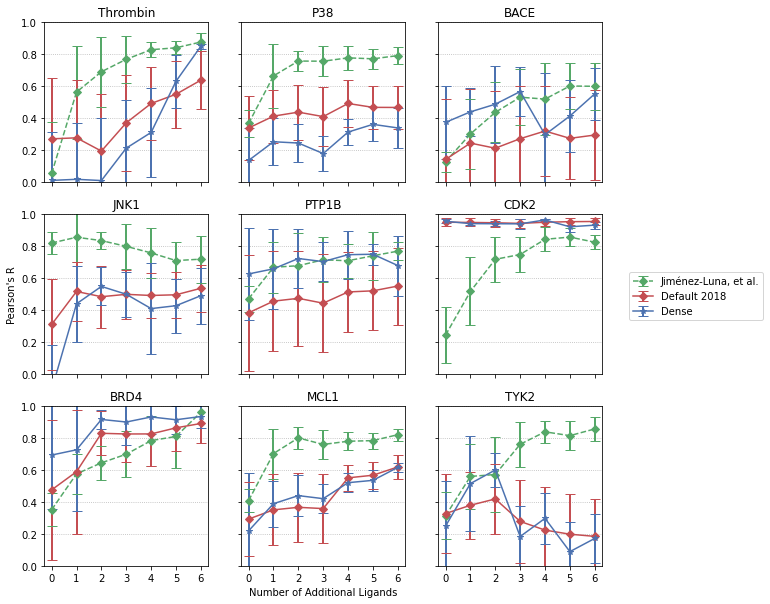

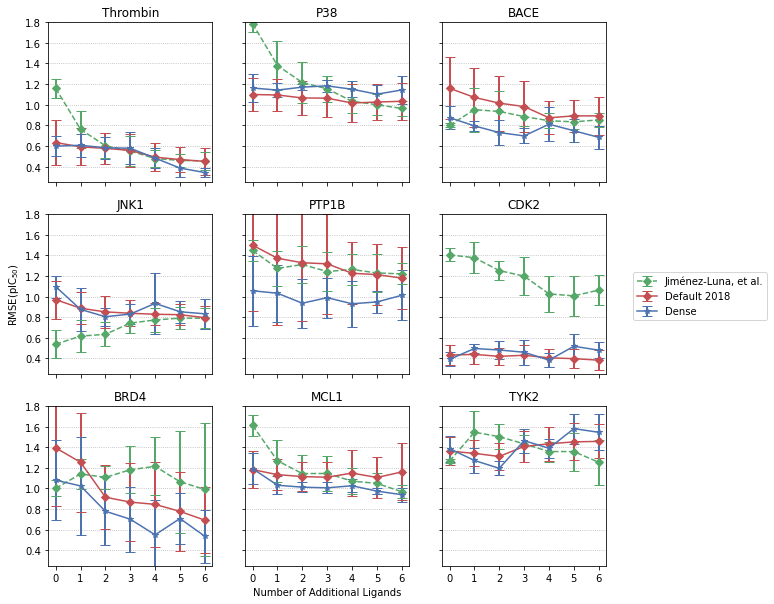

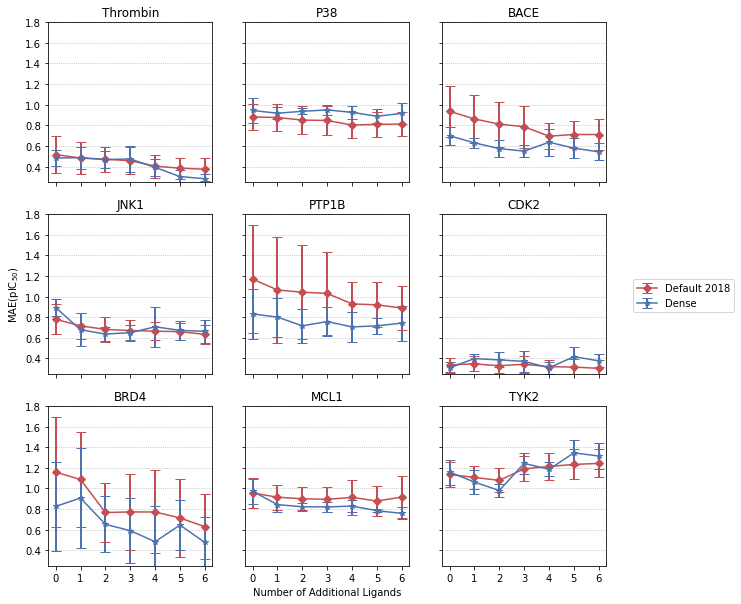

In [330]:
# external_ts = [ext_set.split('/')[-2] for ext_set in sorted(glob('external_test/*/'))]
rfig, raxes = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharex=True,sharey=True)
rmsefig, rmseaxes = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharex=True,sharey=True)
maefig, maeaxes = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharex=True,sharey=True)
for idx, test_set in enumerate(paper_values.keys()):
    val = [idx // 3, idx % 3]
    raxes[val[0],val[1]].set_title(test_set)
    theirs = raxes[val[0],val[1]].errorbar(paper_values[test_set]['R'].index,paper_values[test_set]['R']['y'],yerr=paper_values[test_set]['R']['std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    def2018 = raxes[val[0],val[1]].errorbar(external_set_def2018[f'{test_set}']['addnl'],external_set_def2018[f'{test_set}']['mean_PearsonR'],yerr=external_set_def2018[f'{test_set}']['std_PearsonR'],label='Default 2018',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    dense = raxes[val[0],val[1]].errorbar(external_set_dense[f'{test_set}']['addnl'],external_set_dense[f'{test_set}']['mean_PearsonR'],yerr=external_set_dense[f'{test_set}']['std_PearsonR'],label='Dense',c='b',markeredgewidth=1,capsize=5,elinewidth=2,marker='*')

    if val[1] == 0 and val[0] == 1:
        raxes[val[0],val[1]].set_ylabel("Pearson's R")
    if val[0] == 2 and val[1] == 1:
        raxes[val[0],val[1]].set_xlabel('Number of Additional Ligands')
#     raxes[val[0],val[1]].legend()
#     ax = plt.gca()
    
    raxes[val[0],val[1]].set_ylim(bottom=0,top=1)
    raxes[val[0],val[1]].locator_params(axis='both',nbins=7)
    raxes[val[0],val[1]].grid(axis='y',linestyle=':')
    if val[0] == 2 and val[1] == 2:
        r_leg = rfig.legend([theirs,def2018,dense],['Jiménez-Luna, et al.','Default 2018', 'Dense'],loc='center left',bbox_to_anchor=(0.93, 0.5))

    rmseaxes[val[0],val[1]].set_title(test_set)
    theirs= rmseaxes[val[0],val[1]].errorbar(paper_values[test_set]['RMSE'].index,paper_values[test_set]['RMSE']['y'],yerr=paper_values[test_set]['RMSE']['std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    def2018 = rmseaxes[val[0],val[1]].errorbar(external_set_def2018[f'{test_set}']['addnl'],external_set_def2018[f'{test_set}']['mean_RMSE'],yerr=external_set_def2018[f'{test_set}']['std_RMSE'],label='Default 2018',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    dense = rmseaxes[val[0],val[1]].errorbar(external_set_dense[f'{test_set}']['addnl'],external_set_dense[f'{test_set}']['mean_RMSE'],yerr=external_set_dense[f'{test_set}']['std_RMSE'],label='Dense',c='b',markeredgewidth=1,capsize=5,elinewidth=2,marker='*')
    if val[0] == 2 and val[1] == 1:
        rmseaxes[val[0],val[1]].set_xlabel('Number of Additional Ligands')
    if val[1] == 0 and val[0] == 1:
        rmseaxes[val[0],val[1]].set_ylabel("RMSE(pIC$_{50}$)")
    if val[0] == 0 and val[1] == 2:
        rmse_leg = rmsefig.legend([theirs,def2018,dense],['Jiménez-Luna, et al.','Default 2018', 'Dense'],loc='center left',bbox_to_anchor=(.93, 0.5))
    rmseaxes[val[0],val[1]].grid(axis='y',linestyle=':')
    rmseaxes[val[0],val[1]].set_ylim(bottom=0.25,top=1.8)
    rmseaxes[val[0],val[1]].locator_params(axis='both',nbins=8)
    
    maeaxes[val[0],val[1]].set_title(test_set)
    def2018 = maeaxes[val[0],val[1]].errorbar(external_set_def2018[f'{test_set}']['addnl'],external_set_def2018[f'{test_set}']['mean_MAE'],yerr=external_set_def2018[f'{test_set}']['std_MAE'],label='Default 2018',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    dense = maeaxes[val[0],val[1]].errorbar(external_set_dense[f'{test_set}']['addnl'],external_set_dense[f'{test_set}']['mean_MAE'],yerr=external_set_dense[f'{test_set}']['std_MAE'],label='Dense',c='b',markeredgewidth=1,capsize=5,elinewidth=2,marker='*')
    if val[0] == 2 and val[1] == 1:
        maeaxes[val[0],val[1]].set_xlabel('Number of Additional Ligands')
    if val[1] == 0 and val[0] == 1:
        maeaxes[val[0],val[1]].set_ylabel("MAE(pIC$_{50}$)")
    if val[0] == 2 and val[1] == 2:
        mae_leg = maefig.legend([def2018,dense],['Default 2018', 'Dense'],loc='center left',bbox_to_anchor=(0.93, 0.5))
    maeaxes[val[0],val[1]].grid(axis='y',linestyle=':')
    maeaxes[val[0],val[1]].set_ylim(bottom=0.25,top=1.8)
    maeaxes[val[0],val[1]].locator_params(axis='both',nbins=8)
rfig.savefig('figs/external_test_R.pdf',bbox_inches='tight',transparent=False)
rmsefig.savefig('figs/external_test_RMSE.pdf',bbox_inches='tight',transparent=False)
maefig.savefig('figs/external_test_MAE.pdf',bbox_inches='tight',transparent=False)

In [331]:
external_set_def2018_hlr = {dset:pd.read_csv(f'models/full_train/def2018/{dset}/statistics_fs_hlr.csv') for dset in["BACE","BRD4","CDK2","JNK1","MCL1","P38","PTP1B","Thrombin","TYK2"] }
external_set_dense_hlr = {dset:pd.read_csv(f'models/full_train/dense/{dset}/statistics_fs_hlr.csv') for dset in["BACE","BRD4","CDK2","JNK1","MCL1","P38","PTP1B","Thrombin","TYK2"] }

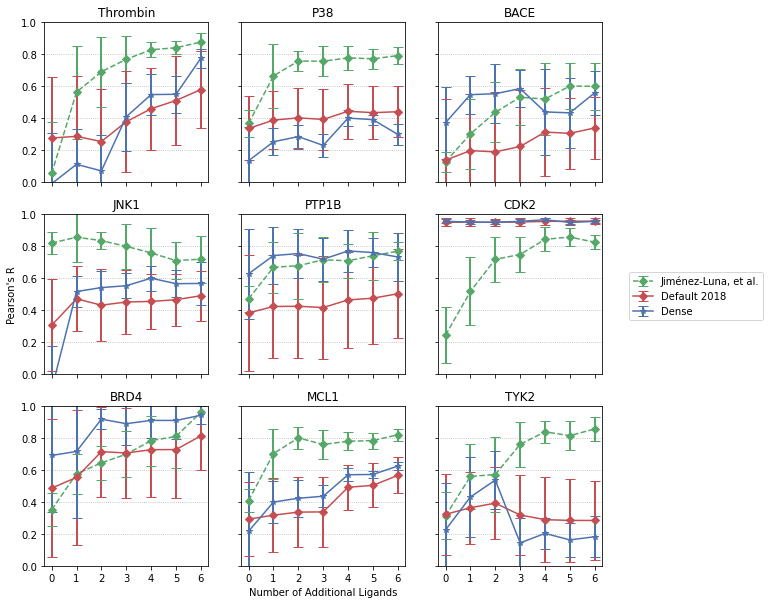

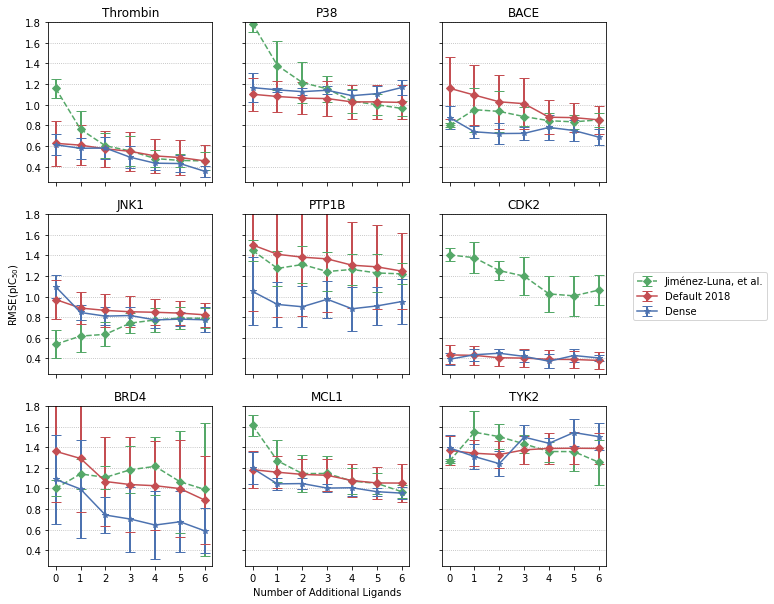

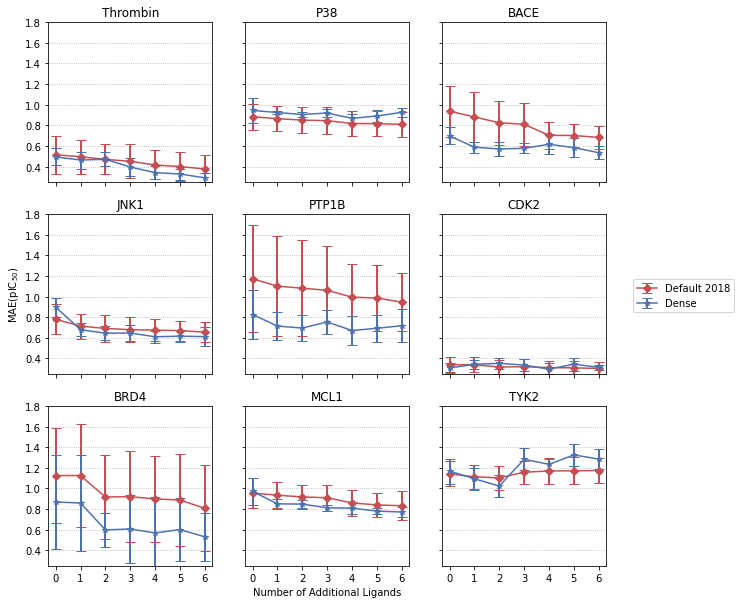

In [332]:
# external_ts = [ext_set.split('/')[-2] for ext_set in sorted(glob('external_test/*/'))]
rfig, raxes = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharex=True,sharey=True)
rmsefig, rmseaxes = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharex=True,sharey=True)
maefig, maeaxes = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharex=True,sharey=True)
for idx, test_set in enumerate(paper_values.keys()):
    val = [idx // 3, idx % 3]
    raxes[val[0],val[1]].set_title(test_set)
    theirs = raxes[val[0],val[1]].errorbar(paper_values[test_set]['R'].index,paper_values[test_set]['R']['y'],yerr=paper_values[test_set]['R']['std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    def2018 = raxes[val[0],val[1]].errorbar(external_set_def2018_hlr[f'{test_set}']['addnl'],external_set_def2018_hlr[f'{test_set}']['mean_PearsonR'],yerr=external_set_def2018_hlr[f'{test_set}']['std_PearsonR'],label='Default 2018',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    dense = raxes[val[0],val[1]].errorbar(external_set_dense_hlr[f'{test_set}']['addnl'],external_set_dense_hlr[f'{test_set}']['mean_PearsonR'],yerr=external_set_dense_hlr[f'{test_set}']['std_PearsonR'],label='Dense',c='b',markeredgewidth=1,capsize=5,elinewidth=2,marker='*')

    if val[1] == 0 and val[0] == 1:
        raxes[val[0],val[1]].set_ylabel("Pearson's R")
    if val[0] == 2 and val[1] == 1:
        raxes[val[0],val[1]].set_xlabel('Number of Additional Ligands')
#     raxes[val[0],val[1]].legend()
#     ax = plt.gca()
    
    raxes[val[0],val[1]].set_ylim(bottom=0,top=1)
    raxes[val[0],val[1]].locator_params(axis='both',nbins=7)
    raxes[val[0],val[1]].grid(axis='y',linestyle=':')
    if val[0] == 2 and val[1] == 2:
        r_leg = rfig.legend([theirs,def2018,dense],['Jiménez-Luna, et al.','Default 2018', 'Dense'],loc='center left',bbox_to_anchor=(0.93, 0.5))

    rmseaxes[val[0],val[1]].set_title(test_set)
    theirs= rmseaxes[val[0],val[1]].errorbar(paper_values[test_set]['RMSE'].index,paper_values[test_set]['RMSE']['y'],yerr=paper_values[test_set]['RMSE']['std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    def2018 = rmseaxes[val[0],val[1]].errorbar(external_set_def2018_hlr[f'{test_set}']['addnl'],external_set_def2018_hlr[f'{test_set}']['mean_RMSE'],yerr=external_set_def2018_hlr[f'{test_set}']['std_RMSE'],label='Default 2018',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    dense = rmseaxes[val[0],val[1]].errorbar(external_set_dense_hlr[f'{test_set}']['addnl'],external_set_dense_hlr[f'{test_set}']['mean_RMSE'],yerr=external_set_dense_hlr[f'{test_set}']['std_RMSE'],label='Dense',c='b',markeredgewidth=1,capsize=5,elinewidth=2,marker='*')
    if val[0] == 2 and val[1] == 1:
        rmseaxes[val[0],val[1]].set_xlabel('Number of Additional Ligands')
    if val[1] == 0 and val[0] == 1:
        rmseaxes[val[0],val[1]].set_ylabel("RMSE(pIC$_{50}$)")
    if val[0] == 0 and val[1] == 2:
        rmse_leg = rmsefig.legend([theirs,def2018,dense],['Jiménez-Luna, et al.','Default 2018', 'Dense'],loc='center left',bbox_to_anchor=(.93, 0.5))
    rmseaxes[val[0],val[1]].grid(axis='y',linestyle=':')
    rmseaxes[val[0],val[1]].set_ylim(bottom=0.25,top=1.8)
    rmseaxes[val[0],val[1]].locator_params(axis='both',nbins=8)
    
    maeaxes[val[0],val[1]].set_title(test_set)
    def2018 = maeaxes[val[0],val[1]].errorbar(external_set_def2018_hlr[f'{test_set}']['addnl'],external_set_def2018_hlr[f'{test_set}']['mean_MAE'],yerr=external_set_def2018_hlr[f'{test_set}']['std_MAE'],label='Default 2018',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    dense = maeaxes[val[0],val[1]].errorbar(external_set_dense_hlr[f'{test_set}']['addnl'],external_set_dense_hlr[f'{test_set}']['mean_MAE'],yerr=external_set_dense_hlr[f'{test_set}']['std_MAE'],label='Dense',c='b',markeredgewidth=1,capsize=5,elinewidth=2,marker='*')
    if val[0] == 2 and val[1] == 1:
        maeaxes[val[0],val[1]].set_xlabel('Number of Additional Ligands')
    if val[1] == 0 and val[0] == 1:
        maeaxes[val[0],val[1]].set_ylabel("MAE(pIC$_{50}$)")
    if val[0] == 2 and val[1] == 2:
        mae_leg = maefig.legend([def2018,dense],['Default 2018', 'Dense'],loc='center left',bbox_to_anchor=(0.93, 0.5))
    maeaxes[val[0],val[1]].grid(axis='y',linestyle=':')
    maeaxes[val[0],val[1]].set_ylim(bottom=0.25,top=1.8)
    maeaxes[val[0],val[1]].locator_params(axis='both',nbins=8)
rfig.savefig('figs/external_test_R.pdf',bbox_inches='tight',transparent=False)
rmsefig.savefig('figs/external_test_RMSE.pdf',bbox_inches='tight',transparent=False)
maefig.savefig('figs/external_test_MAE.pdf',bbox_inches='tight',transparent=False)

In [17]:
def get_paper_compare(use_model,dropout,strat_rec,finetune_fname):
    if dropout == 0:
        dropout = int(dropout)
    runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
             filters={"$and":[{"config.use_model":use_model},{'config.trainfile':'all_newdata.types'},
                             {"config.dropout":dropout},{"config.stratify_rec":strat_rec},{"config.eval":True},{"state":"finished"}]})
    our_data = pd.DataFrame(columns=external_dataset_measures)
    for run in runs:
    #     print(run)
        new_row = pd.DataFrame.from_dict(run.history(keys=external_dataset_measures,pandas=False)[0][0],orient='index').T
        our_data = our_data.append(new_row,ignore_index=True)
    final_data = pd.concat([our_data.mean(axis=0),our_data.std(axis=0)],axis=1)
    final_data.columns = ['mean','std']
    rfig, raxes = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharex=True,sharey=True)
    rmsefig, rmseaxes = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharex=True,sharey=True)
    for idx, test_set in enumerate(paper_values.keys()):
        val = [idx // 3, idx % 3]
        finetune_df = get_finetune(test_set,finetune_fname)
        raxes[val[0],val[1]].set_title(test_set)
        theirs = raxes[val[0],val[1]].errorbar(paper_values[test_set]['R'].index,paper_values[test_set]['R']['y'],yerr=paper_values[test_set]['R']['std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
        ours = raxes[val[0],val[1]].errorbar(0,final_data.loc[f'{test_set}.Test R','mean'],yerr=final_data.loc[f'{test_set}.Test R','std'],label='Our Model',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
        if finetune_df is not None:
            raxes[val[0],val[1]].errorbar([int(val) for val in finetune_df.index.tolist()],finetune_df['Avg R'],yerr=finetune_df['Stddev R'],c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
            raxes[val[0],val[1]].plot([0,1],[float(final_data.loc[f'{test_set}.Test R','mean']),float(finetune_df.loc['1','Avg R'])],c='r')
        if val[1] == 0 and val[0] == 1:
            raxes[val[0],val[1]].set_ylabel("Pearson's R")
        if val[0] == 2 and val[1] == 1:
            raxes[val[0],val[1]].set_xlabel('Number of Additional Ligands')
    #     raxes[val[0],val[1]].legend()
    #     ax = plt.gca()

        raxes[val[0],val[1]].set_ylim(bottom=0,top=1)
        raxes[val[0],val[1]].locator_params(axis='both',nbins=7)
        raxes[val[0],val[1]].grid(axis='y',linestyle=':')
        if val[0] == 2 and val[1] == 2:
            r_leg = rfig.legend([theirs,ours],['Jiménez-Luna, et al.','Our Model'],loc='center left',bbox_to_anchor=(1, 0.5))
        
        rmseaxes[val[0],val[1]].set_title(test_set)
        theirs= rmseaxes[val[0],val[1]].errorbar(paper_values[test_set]['RMSE'].index,paper_values[test_set]['RMSE']['y'],yerr=paper_values[test_set]['RMSE']['std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
        ours = rmseaxes[val[0],val[1]].errorbar(0,final_data.loc[f'{test_set}.Test RMSE','mean'],yerr=final_data.loc[f'{test_set}.Test RMSE','std'],label='Our Model',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
        if finetune_df is not None:
            rmseaxes[val[0],val[1]].errorbar([int(val) for val in finetune_df.index.tolist()],finetune_df['Avg RMSE'],yerr=finetune_df['Stddev RMSE'],c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
            rmseaxes[val[0],val[1]].plot([0,1],[float(final_data.loc[f'{test_set}.Test RMSE','mean']),float(finetune_df.loc['1','Avg RMSE'])],c='r')
        if val[0] == 2 and val[1] == 1:
            rmseaxes[val[0],val[1]].set_xlabel('Number of Additional Ligands')
        if val[1] == 0 and val[0] == 1:
            rmseaxes[val[0],val[1]].set_ylabel("RMSE(pIC$_{50}$)")
        if val[0] == 2 and val[1] == 2:
            rmse_leg = rmsefig.legend([theirs,ours],['Jiménez-Luna, et al.','Our Model'],loc='center left',bbox_to_anchor=(1, 0.5))
        rmseaxes[val[0],val[1]].grid(axis='y',linestyle=':')
        rmseaxes[val[0],val[1]].set_ylim(bottom=0.25,top=1.8)
        rmseaxes[val[0],val[1]].locator_params(axis='both',nbins=8)
#     rfig.savefig('external_test/external_test_R.png',bbox_inches='tight',transparent=False)
#     rmsefig.savefig('external_test/external_test_RMSE.png',bbox_inches='tight',transparent=False)

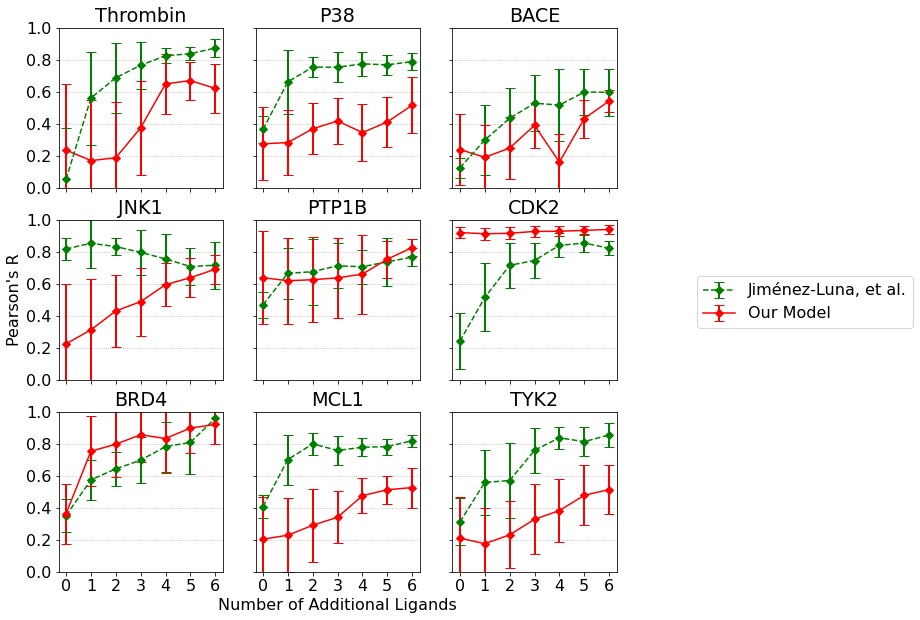

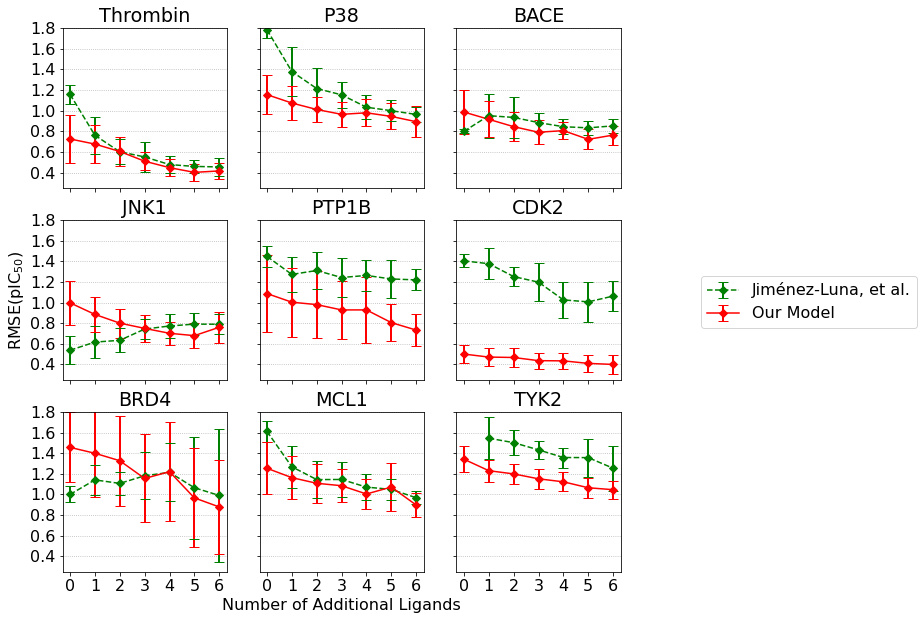

In [18]:
get_paper_compare('multtask_latent_def2018',0.5,False,'finetune_D5')

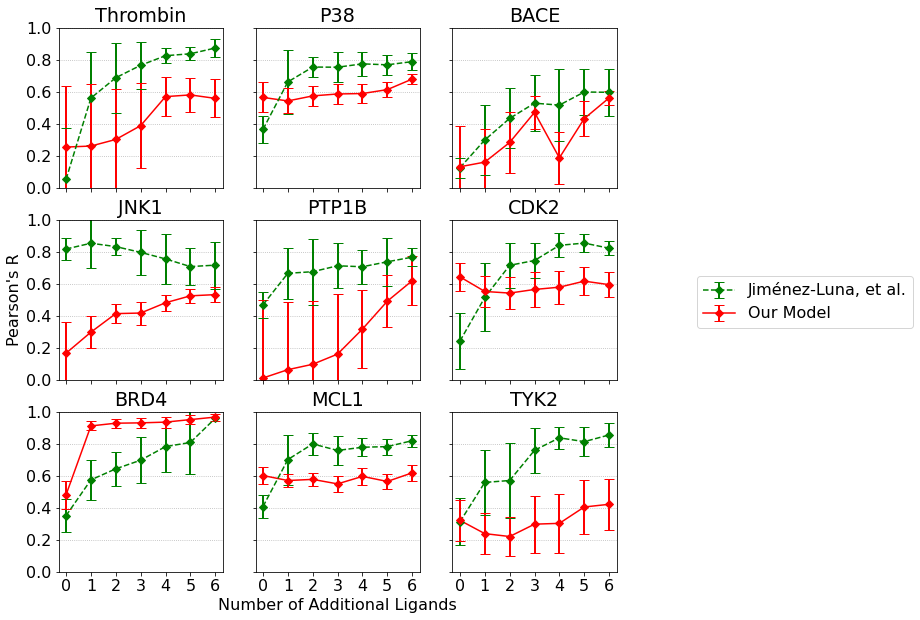

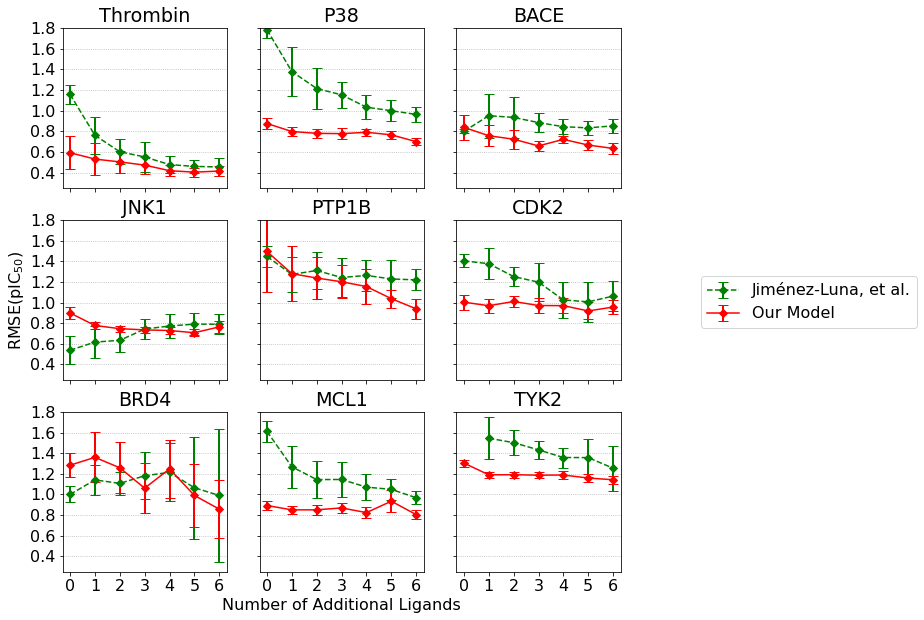

In [19]:
get_paper_compare('multtask_latent_def2018',0.5,True,'finetune_D5_SR')

/home/anm329/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


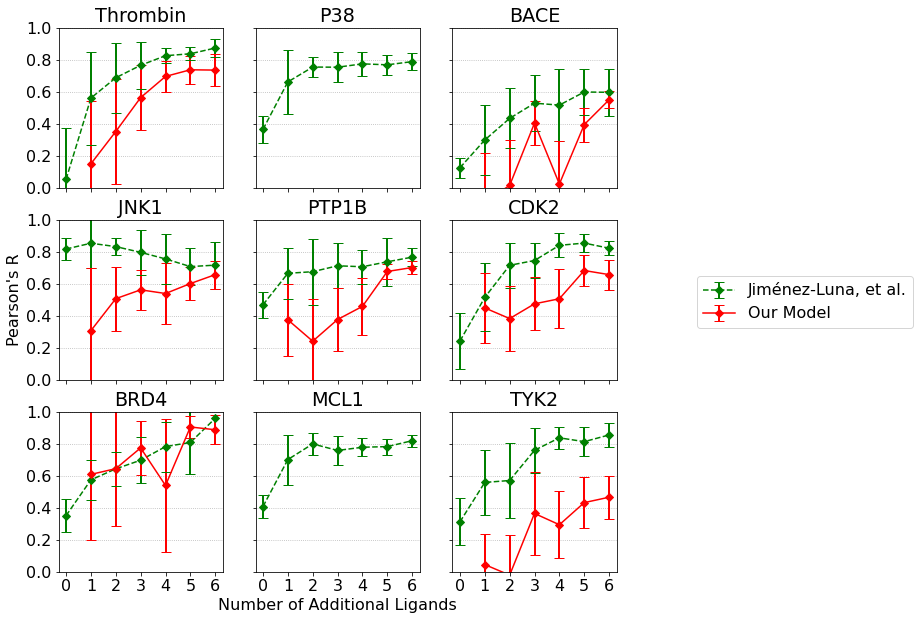

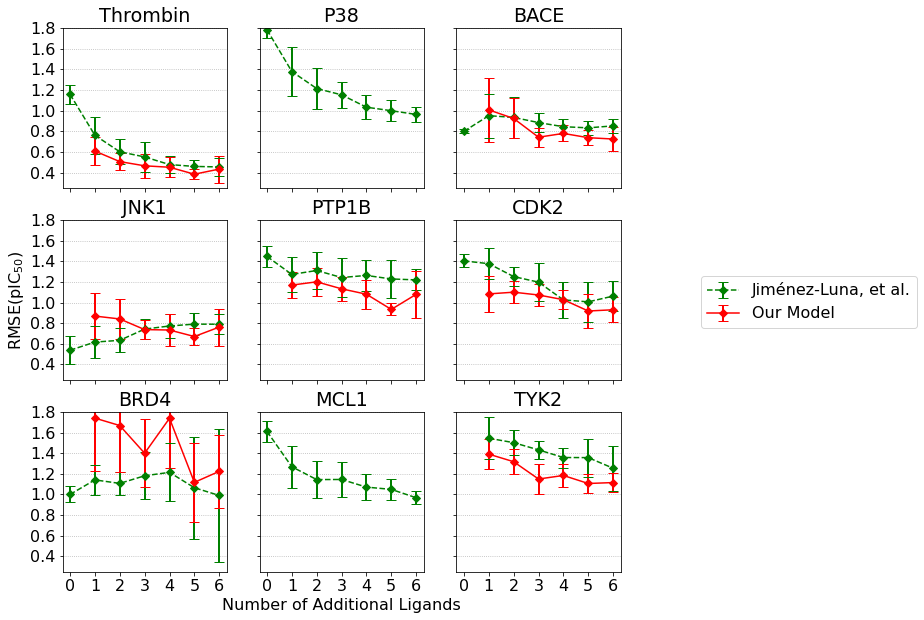

In [20]:
get_paper_compare('multtask_latent_def2018_concat',0,True,'finetune_concat_SR')